# Sprint 2 - Molelo de Regressão para Prever o Preço de Carros


## Descrição das Variáveis
* **manufacturer**: nome do fabricante.
* **model**: modelo do carro.
* **year**: ano de produção.
* **mileage**: número de milhas percorridas.
* **engine**: descrição do motor.
* **transmission**: tipo de transmissão.
* **drivetrain**: tipo de tração.
* **fuel_type**: tipo de combustível.
* **mpg**: milhas por galão.
* **exterior_color**: cor externa.
* **interior_color**: cor interna.
* **accidents_or_damage**: Envolvimento em acidentes (1 = sim / 0 = não).
* **one_owner**: Único dono (1 = sim / 0 = não).
* **personal_use_only**: Apenas uso pessoal (1 = sim / 0 = não).
* **seller_name**: Nome do vendedor.
* **seller_rating**: Avaliação do vendedor.
* **driver_rating**: Avaliação do carro pelos motoristas.
* **driver_reviews_num**: Número de avaliações pelos motoristas.
* **price_drop**: Redução do preço em relação ao preço inicial.
* **price**: Preço do carro.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import re

np.random.seed(55)

In [4]:
df = pd.read_csv('cars.csv')

Decidi filtrar o dataframe com base nos quartis para evitar outliers. Esta etapa foi colocada no final, pois ao pegar aleatoriamente os 25% sem considerar os quartis, qualquer modelo de previsão ficou com uma margem de erro acima de 11.000 dolares, mesmo eliminando os outliers durante o tratamento.

In [5]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

# Intervalo interquartil
IQR = Q3 - Q1

# Definindo os limites inferiores e superiores
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrando os dados dentro do intervalo interquartil
df_sem_outliers = df[(df['price'] >= limite_inferior) & (df['price'] <= limite_superior)]

# pegando a amostra
c_df = df_sem_outliers.sample(frac=0.25,random_state=77)

# 1. Análise Exploratória dos Dados – pré-limpeza

In [6]:
c_df.head()

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
499001,Mazda,Mazda6 i Touring,2015,110208.0,2.5L I4 16V GDI DOHC,6-Speed Manual,FWD,Gasoline,25-37,Soul Red Metallic,Sand,NaN,NaN,NaN,AutoNation Toyota Hayward,4.3,4.7,114.0,503.0,14238.0
601703,Nissan,NV Cargo SV,2012,462232.0,4.0L V6 24V MPFI DOHC,Automatic,Rear-wheel Drive,Gasoline,NaN,Blizzard,Charcoal,0.0,1.0,1.0,East Coast Auto Source,1.8,4.3,7.0,NaN,7795.0
65860,Buick,Enclave Convenience,2015,137000.0,3.6L V6 24V GDI DOHC,6-Speed Automatic,Front-wheel Drive,Gasoline,17-24,Quicksilver Metallic,Light Titanium,0.0,0.0,1.0,Alfa Romeo of Minneapolis,4.8,4.6,72.0,502.0,12995.0
77630,Buick,LaCrosse CXL,2005,106000.0,3.8L V6 12V MPFI OHV,4-Speed Automatic,Front-wheel Drive,Gasoline,20-29,Silver,Ebony,1.0,0.0,0.0,Lux Auto Depot Limited,NaN,4.4,37.0,NaN,2995.0
191410,Ford,Focus SE,2016,60097.0,2.0L I4 16V GDI DOHC Flexible Fuel,Automatic,Front-wheel Drive,E85 Flex Fuel,26-36,Oxford White,Charcoal Black,1.0,0.0,1.0,Bob Rohrman's Indy Hyundai-Genesis,4.6,4.4,193.0,NaN,12444.0


In [7]:
c_df.tail()

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
635866,RAM,ProMaster 2500 High Roof,2021,16970.0,3.6L V6 24V MPFI DOHC,6-Speed Automatic,Front-wheel Drive,Gasoline,NaN,Bright White Clearcoat,Black,0.0,1.0,0.0,Merchants Automotive Group,4.1,NaN,0.0,6400.0,44500.0
300773,Honda,Fit Base,2012,94634.0,1.5L I4 16V MPFI SOHC,5-Speed Automatic,Front-wheel Drive,Gasoline,28-35,White,Gray,1.0,0.0,1.0,CarMax Garland - Offering Express Pickup and H...,NaN,4.6,79.0,NaN,13599.0
168105,Dodge,Grand Caravan GT,2019,41731.0,3.6L V6 24V MPFI DOHC,Automatic,Front-wheel Drive,Gasoline,17-25,Billet Clearcoat,Black,0.0,0.0,0.0,Roseville Toyota,4.3,4.7,70.0,2011.0,20977.0
511381,Mercedes-Benz,CLA-Class CLA 250,2014,77000.0,2.0L I4 16V GDI SOHC Turbo,7-Speed Automatic with Auto-Shift,Front-wheel Drive,Gasoline,26-38,Citrus White,Black,0.0,1.0,1.0,Central Florida Toyota,4.7,4.6,85.0,500.0,18477.0
72376,Buick,Encore GX Select,2021,25102.0,1.2L I3 12V GDI DOHC Turbo,Automatic CVT,Front-wheel Drive,Gasoline,28-31,Burnished Bronze Metallic,Ebony,0.0,1.0,1.0,Galleria BMW,4.7,4.5,28.0,1061.0,25890.0


In [8]:
c_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181314 entries, 499001 to 72376
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   manufacturer         181314 non-null  object 
 1   model                181314 non-null  object 
 2   year                 181314 non-null  int64  
 3   mileage              181211 non-null  float64
 4   engine               177936 non-null  object 
 5   transmission         179138 non-null  object 
 6   drivetrain           176468 non-null  object 
 7   fuel_type            176043 non-null  object 
 8   mpg                  150193 non-null  object 
 9   exterior_color       179201 non-null  object 
 10  interior_color       167807 non-null  object 
 11  accidents_or_damage  175656 non-null  float64
 12  one_owner            174184 non-null  float64
 13  personal_use_only    175526 non-null  float64
 14  seller_name          179302 non-null  object 
 15  seller_rating     

Podemos notar que há bastante dados faltantes no dataset. Além disso, podemos perceber que, ao menos em sua grande maioria, os tipos dos dados estão corretos e não será necessário alterá-los.

In [9]:
pd.options.display.float_format = '{:.2f}'.format
c_df.describe()

,year,mileage,accidents_or_damage,one_owner,personal_use_only,seller_rating,driver_rating,driver_reviews_num,price_drop,price
count,181314.00,181211.00,175656.00,174184.00,175526.00,129796.00,176227.00,181314.00,97740.00,181314.00
mean,2017.69,57836.29,0.24,0.56,0.65,4.16,4.63,93.87,929.78,29067.70
std,4.92,43716.63,0.42,0.50,0.48,0.81,0.27,116.61,1021.50,13524.99
min,1915.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,100.00,299.00
25%,2016.00,25319.50,0.00,0.00,0.00,3.80,4.50,17.00,364.00,18998.00
50%,2019.00,48010.00,0.00,1.00,1.00,4.50,4.70,55.00,600.00,26995.00
75%,2021.00,80770.50,0.00,1.00,1.00,4.70,4.80,126.00,1000.00,37237.00
max,2024.00,999999.00,1.00,1.00,1.00,5.00,5.00,1025.00,50450.00,69333.00


Já de início, notamos que os valores máximos de ```mileage``` apresenta outliers.

Alguns valores são claramente erros de digitação, uma vez que impraticáveis. Alguns dos carros teriam que andar mais de 100km/dia, todos os dias do ano por mais de uma década.

In [10]:
# possíveis outliers em mileage
c_df[c_df['mileage'] > 499999.00].head(10)

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
511961,Mercedes-Benz,GLK-Class GLK 350,2011,999999.00,3.5L V6 24V MPFI DOHC,7-Speed Automatic,Rear-wheel Drive,Gasoline,16-23,Black,NaN,1.00,0.00,1.00,Duluth Auto Exchange,NaN,4.50,32.00,NaN,13995.00
302334,Honda,Pilot LX,2020,754680.00,3.5L V6 24V GDI SOHC,6-Speed Automatic,Front-wheel Drive,Gasoline,19-27,Platinum White Pearl,Black,0.00,1.00,1.00,Florida Fine Cars Margate,5.00,4.30,156.00,500.00,20499.00
76422,Buick,Century Custom,1998,999999.00,3.1L V-6 engine with 160HP,Automatic,Front-wheel Drive,Gasoline,20-27,Maroon,Bordeaux Red,0.00,0.00,1.00,Key Lime Automotive LLC,NaN,4.10,11.00,NaN,1995.00
157346,Chrysler,Voyager LXI,2021,724500.00,3.6L V6 24V MPFI DOHC,9-Speed Automatic,Front-wheel Drive,Gasoline,19-28,Brilliant Black Crystal Pearlcoat,Black,0.00,1.00,0.00,AutoNation CDJR FIAT Johnson City,4.40,5.00,1.00,959.00,20491.00
121155,Chevrolet,Trax LS,2018,653132.00,1.4L I4 16V MPFI DOHC Turbo,6-Speed Automatic,Front-wheel Drive,Gasoline,25-33,Storm Blue Metallic,Jet Black,0.00,1.00,1.00,AutoNation Chevrolet North Corpus Christi,4.70,4.60,206.00,NaN,15287.00
304515,Honda,Pilot EX-L,2005,516000.00,3.5L V6 24V MPFI SOHC,5-Speed Automatic,Four-wheel Drive,Gasoline,17-22,Blue,Gray,0.00,0.00,1.00,Big Man Motors,NaN,4.60,68.00,1000.00,5160.00
319941,Honda,Civic LX,2013,938032.00,1.8L I4 16V MPFI SOHC,5-Speed Automatic,Front-wheel Drive,Gasoline,28-39,Dyno Blue Pearl,Black,0.00,0.00,1.00,Lithia Ford of Roseburg,3.90,4.60,287.00,872.00,14816.00


Vamos tratar esses outliers no item 2.

Agora vejamos alguns dados faltantes:

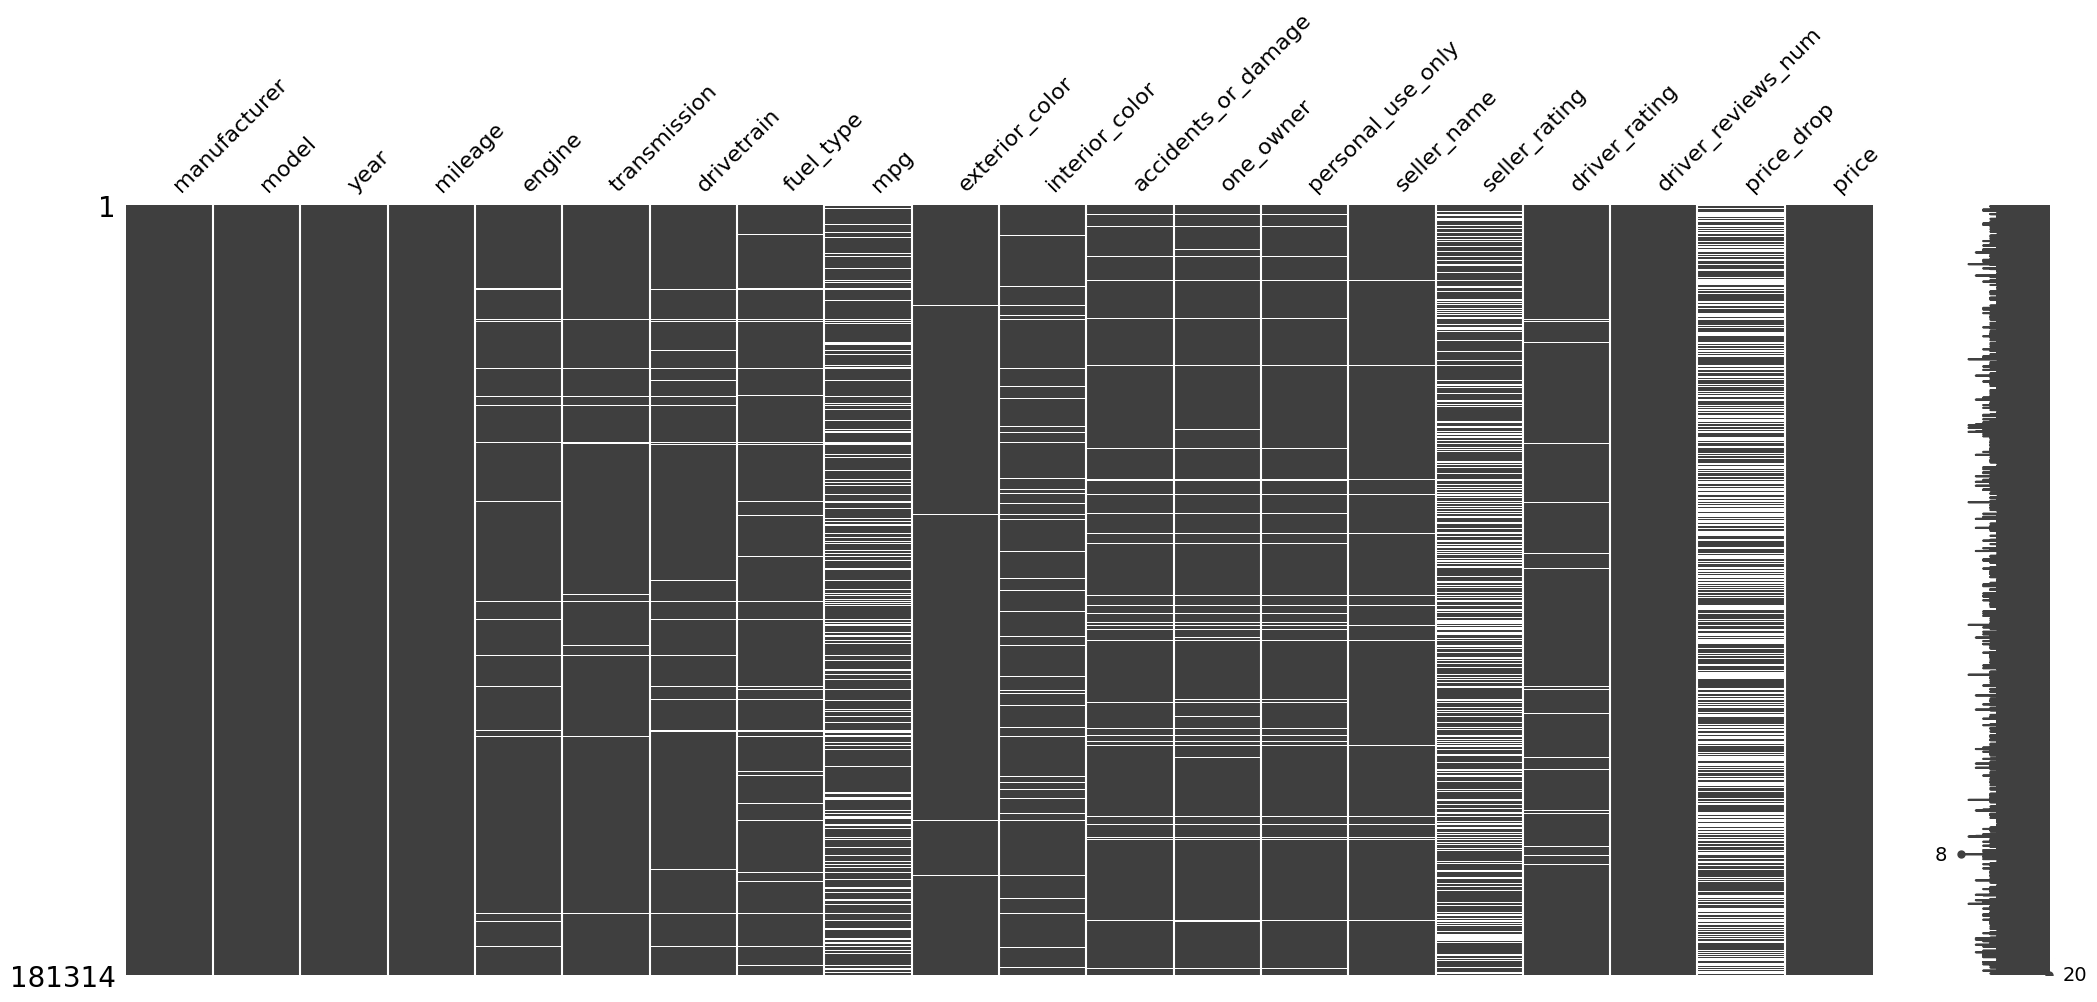

In [11]:
import missingno as msno
msno.matrix(c_df)
plt.show()

Acima, podemos ver que quase todas as colunas possuem valores faltantes, com exceção de ```manufacturer```, ```model```, ```year```, ```mileage```, ```driver_reviews_num``` e ```price```. 

# 2. Limpeza dos Dados

## 2.1 Coluna ```mileage```

In [12]:
# Criando um limite para mileage utilizando quartis
def filter_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Adicionando a coluna de década a fim de segmentar os dados
c_df['decade'] = (c_df['year'] // 10) * 10

# Aplicando o filtro de outliers para cada década
filtered_df_list = []
for decade in c_df['decade'].unique():
    df_decade = c_df[c_df['decade'] == decade]
    filtered_df_decade = filter_outliers_iqr(df_decade, 'mileage')
    filtered_df_list.append(filtered_df_decade)

cars_df = pd.concat(filtered_df_list)

cars_df = cars_df.drop(columns=['decade'])

cars_df.describe()


,year,mileage,accidents_or_damage,one_owner,personal_use_only,seller_rating,driver_rating,driver_reviews_num,price_drop,price
count,178533.00,178533.00,172969.00,171509.00,172840.00,128019.00,173509.00,178533.00,96458.00,178533.00
mean,2017.72,56104.33,0.23,0.56,0.65,4.16,4.63,94.00,929.90,29202.46
std,4.91,40692.64,0.42,0.50,0.48,0.81,0.27,116.99,1022.57,13481.37
min,1915.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,100.00,299.00
25%,2016.00,25017.00,0.00,0.00,0.00,3.80,4.50,17.00,364.25,19069.00
50%,2019.00,47192.00,0.00,1.00,1.00,4.50,4.70,55.00,600.00,26999.00
75%,2021.00,78893.00,0.00,1.00,1.00,4.70,4.80,126.00,1000.00,37465.00
max,2024.00,300000.00,1.00,1.00,1.00,5.00,5.00,1025.00,50450.00,69333.00


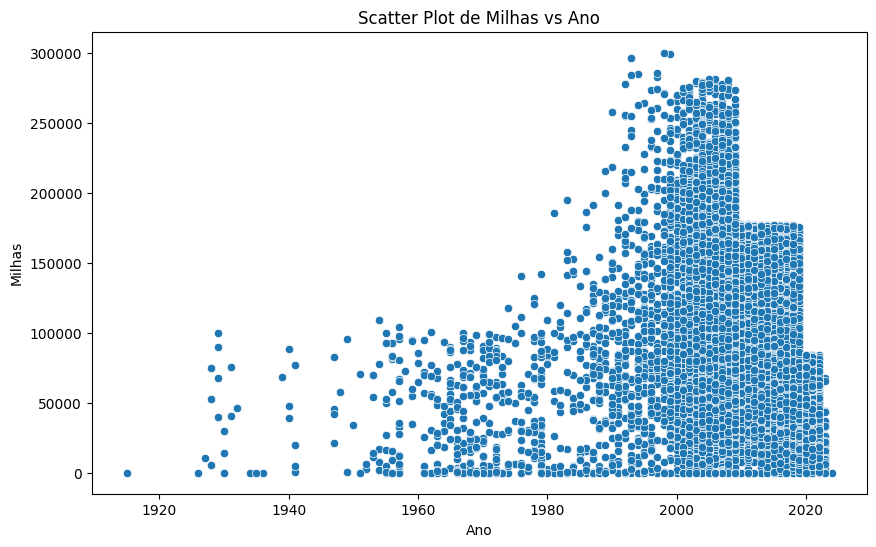

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='mileage', data=cars_df)
plt.title('Scatter Plot de Milhas vs Ano')
plt.xlabel('Ano')
plt.ylabel('Milhas')
plt.show()

## 2.2 Coluna ```price```

In [14]:
cars_df['price'].describe()

count   178533.00
mean     29202.46
std      13481.37
min        299.00
25%      19069.00
50%      26999.00
75%      37465.00
max      69333.00
Name: price, dtype: float64

Agora podemos ver com mais clareza a distribuição dos valores em ```price``` ao longo dos anos.

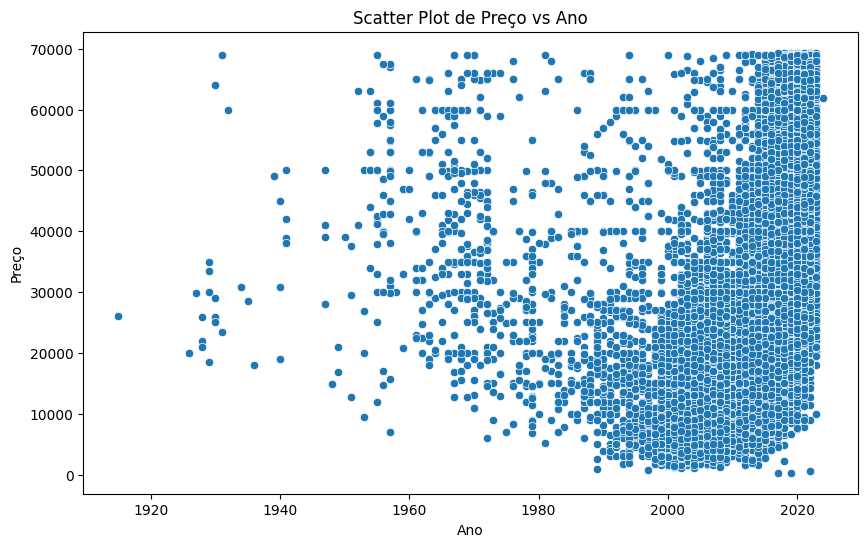

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='price', data=cars_df)
plt.title('Scatter Plot de Preço vs Ano')
plt.xlabel('Ano')
plt.ylabel('Preço')
plt.show()

Tive dúvida sobre como interpretar esse plot. De primeira, identifiquei apenas uma leve correlação direta entre preço e ano, focando na curva ascendente a partir dos anos 90. No entanto, após análise mais atenta, percebi que isso parece ser um erro induzido pela quantidade de amostras. Na verdade se desconsiderarmos esse viés, parece na verdade haver uma "barriga" no plot (ou um "U"), com o fundo do "U" sendo por volta de 1980. De 1980 para trás, parece haver uma relação inversa: quanto mais antigo, mais caro. 

Interessante também notar a relação entre preço e milhagem. Conforme vemos abaixo, a relação nesse caso é inversa.

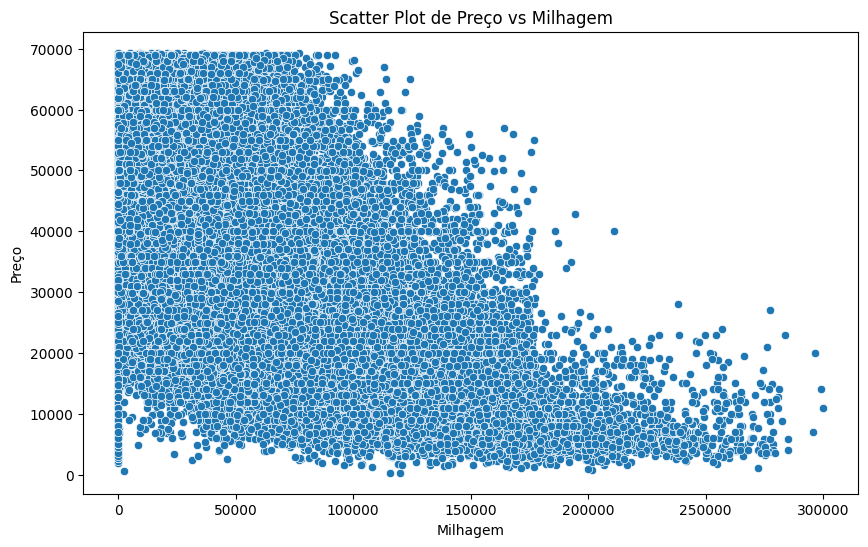

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mileage', y='price', data=cars_df)
plt.title('Scatter Plot de Preço vs Milhagem')
plt.xlabel('Milhagem')
plt.ylabel('Preço')
plt.show()

## 2.3 Coluna ```manufacturer```

In [17]:
cars_df['manufacturer'].value_counts()

manufacturer
Ford             18420
Toyota           14326
Chevrolet        12871
Nissan           11979
Jeep             10174
Honda             9235
Kia               8716
Mercedes-Benz     8702
BMW               8506
GMC               6318
Subaru            6115
Dodge             6010
Volkswagen        5982
Hyundai           5485
Lexus             5174
RAM               4322
Audi              4314
Cadillac          3990
Mazda             3775
Buick             3730
Chrysler          3137
INFINITI          3051
Volvo             2493
Lincoln           2413
Land Rover        2316
Acura             2074
Porsche           1449
Mitsubishi        1354
Tesla             1272
Jaguar             830
Name: count, dtype: int64

## 2.4 Coluna ```model```

In [18]:
cars_df['model'].value_counts()

model
Fusion SE               800
Sportage LX             715
Corolla LE              675
GLC 300 Base 4MATIC     663
Sentra SV               652
                       ... 
DTS 1SC                   1
Spectra LX                1
Colorado W/T              1
G-Class 4dr 4WD 5.0L      1
Model A Base              1
Name: count, Length: 7307, dtype: int64

In [19]:
patterns = {
    r'Fusion SE.*': 'Fusion SE',
    r'Corolla LE.*': 'Corolla LE',
    r'Sportage LX.*': 'Sportage LX',
    r'Sentra SV.*': 'Sentra SV',
    r'GLC 300 Base 4MATIC.*': 'GLC 300 Base 4MATIC',
    r'Optima LX.*': 'Optima LX',
    r'Sorento LX.*': 'Sorento LX',
    r'Explorer XLT.*': 'Explorer XLT',
    r'RX 350 Base.*': 'RX 350 Base',
    r'Tundra SR5.*': 'Tundra SR5',
    r'Rogue SV.*': 'Rogue SV',
    r'Renegade Latitude.*': 'Renegade Latitude',
    r'Wrangler Sport.*': 'Wrangler Sport',
    r'Odyssey EX-L.*': 'Odyssey EX-L',
    r'Edge SEL.*': 'Edge SEL',
    r'Forte LXS.*': 'Forte LXS',
    r'Encore Preferred.*': 'Encore Preferred',
    r'Focus SE.*': 'Focus SE',
    r'F-150 XLT.*': 'F-150 XLT',
    r'Escape SE.*': 'Escape SE',
    r'Highlander XLE.*': 'Highlander XLE',
    r'Tiguan 2.0T SE.*': 'Tiguan 2.0T SE',
    r'Pacifica Touring-L.*': 'Pacifica Touring-L',
    r'Grand Caravan SXT.*': 'Grand Caravan SXT',
    r'Grand Cherokee Limited.*': 'Grand Cherokee Limited',
    r'Frontier SV.*': 'Frontier SV',
    r'Ranger XLT.*': 'Ranger XLT',
    r'RAV4 XLE.*': 'RAV4 XLE',
    r'Wrangler Unlimited Sahara.*': 'Wrangler Unlimited Sahara',
    r'CX-5 Touring.*': 'CX-5 Touring',
    r'Yukon Denali.*': 'Yukon Denali',
    r'Charger SXT.*': 'Charger SXT',
    r'Transit-250 Base.*': 'Transit-250 Base',
    r'Compass Latitude.*': 'Compass Latitude',
    r'Cherokee Limited.*': 'Cherokee Limited',
    r'C-Class C 300.*': 'C-Class C 300',
    r'Malibu LT.*': 'Malibu LT',
    r'Trax LT.*': 'Trax LT',
    r'1500 Big Horn.*': '1500 Big Horn',
    r'Camry SE.*': 'Camry SE',
    r'Pilot EX-L.*': 'Pilot EX-L',
    r'Wrangler Unlimited Sport.*': 'Wrangler Unlimited Sport',
    r'F-250 Lariat.*': 'F-250 Lariat',
    r'Jetta 1.4T S.*': 'Jetta 1.4T S',
    r'Equinox 1LT.*': 'Equinox 1LT',
    r'Civic LX.*': 'Civic LX',
    r'CR-V EX-L.*': 'CR-V EX-L',
    r'Terrain SLE.*': 'Terrain SLE',
    r'Rogue Sport S.*': 'Rogue Sport S',
    r'Altima 2.5 S.*': 'Altima 2.5 S',
    r'Terrain SLT.*': 'Terrain SLT',
    r'CR-V EX.*': 'CR-V EX',
    r'Versa 1.6 SV.*': 'Versa 1.6 SV',
    r'C-Class C 300 4MATIC.*': 'C-Class C 300 4MATIC',
    r'CX-5 Grand Touring.*': 'CX-5 Grand Touring',
    r'XT5 Luxury.*': 'XT5 Luxury',
    r'GLE 350 Base 4MATIC.*': 'GLE 350 Base 4MATIC',
    r'Sierra 2500 Denali.*': 'Sierra 2500 Denali',
    r'QX60 Luxe.*': 'QX60 Luxe',
    r'ES 350 Base.*': 'ES 350 Base',
    r'X3 xDrive30i.*': 'X3 xDrive30i',
    r'X5 xDrive40i.*': 'X5 xDrive40i',
    r'F-350 Lariat Super Duty.*': 'F-350 Lariat Super Duty',
    r'GLC 300 Base.*': 'GLC 300 Base',
    r'Pacifica Limited.*': 'Pacifica Limited',
    r'Murano SL.*': 'Murano SL',
    r'Sierra 1500 SLT.*': 'Sierra 1500 SLT',
    r'Durango GT.*': 'Durango GT',
    r'Acadia Denali.*': 'Acadia Denali',
    r'Compass Limited.*': 'Compass Limited',
    r'2500 Big Horn.*': '2500 Big Horn',
    r'330 i xDrive.*': '330 i xDrive',
    r'GX 460 Base.*': 'GX 460 Base',
    r'Elantra SEL.*': 'Elantra SEL',
    r'EcoSport SE.*': 'EcoSport SE',
    r'1500 Classic SLT.*': '1500 Classic SLT',
    r'4Runner SR5.*': '4Runner SR5',
    r'F-250 XLT.*': 'F-250 XLT',
    r'2500 Laramie.*': '2500 Laramie',
    r'Gladiator Sport.*': 'Gladiator Sport',
    r'Camry LE.*': 'Camry LE',
    r'RAV4 LE.*': 'RAV4 LE',
    r'Yukon SLT.*': 'Yukon SLT',
    r'Expedition Limited.*': 'Expedition Limited',
    r'Trax LS.*': 'Trax LS',
    r'Yukon XL Denali.*': 'Yukon XL Denali',
    r'Blazer 2LT.*': 'Blazer 2LT',
    r'Tahoe LT.*': 'Tahoe LT',
    r'Sienna LE.*': 'Sienna LE',
    r'ProMaster 2500 High Roof.*': 'ProMaster 2500 High Roof',
    r'Gladiator Rubicon.*': 'Gladiator Rubicon',
    r'330 i.*': '330 i',
    r'Soul Base.*': 'Soul Base',
    r'Mustang GT Premium.*': 'Mustang GT Premium',
    r'Sienna XLE.*': 'Sienna XLE',
    r'Edge Titanium.*': 'Edge Titanium',
    r'Q5 2.0T Premium Plus.*': 'Q5 2.0T Premium Plus',
    r'Rogue S.*': 'Rogue S',
    r'Tacoma TRD Off Road.*': 'Tacoma TRD Off Road',
    r'Envision Essence.*': 'Envision Essence'
}

def categorize_model(model):
    for pattern, category in patterns.items():
        if re.match(pattern, model, re.IGNORECASE):
            return category
    return model  

cars_df['category'] = cars_df['model'].apply(categorize_model)

Tentei usar regex para reduzir a quantidade de modelos, mas a tarefa se mostrou infindável. Consegui reduzir de 7307 para 7114, o que não é muito significativo. Assim, a solução terá que ser outra.

In [20]:
cars_df['category'].value_counts()

category
Altima 2.5 S     1069
Fusion SE         930
C-Class C 300     925
Rogue Sport S     817
Escape SE         789
                 ... 
V50 T5              1
Safari SLE          1
Safari Cargo        1
DTS 1SC             1
Model A Base        1
Name: count, Length: 7114, dtype: int64

In [21]:
cars_df.drop('model', axis=1, inplace=True)

cars_df.rename(columns={'category': 'model'}, inplace=True)

In [22]:
cars_df.head()

,manufacturer,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price,model
499001,Mazda,2015,110208.00,2.5L I4 16V GDI DOHC,6-Speed Manual,FWD,Gasoline,25-37,Soul Red Metallic,Sand,NaN,NaN,NaN,AutoNation Toyota Hayward,4.30,4.70,114.00,503.00,14238.00,Mazda6 i Touring
65860,Buick,2015,137000.00,3.6L V6 24V GDI DOHC,6-Speed Automatic,Front-wheel Drive,Gasoline,17-24,Quicksilver Metallic,Light Titanium,0.00,0.00,1.00,Alfa Romeo of Minneapolis,4.80,4.60,72.00,502.00,12995.00,Enclave Convenience
191410,Ford,2016,60097.00,2.0L I4 16V GDI DOHC Flexible Fuel,Automatic,Front-wheel Drive,E85 Flex Fuel,26-36,Oxford White,Charcoal Black,1.00,0.00,1.00,Bob Rohrman's Indy Hyundai-Genesis,4.60,4.40,193.00,NaN,12444.00,Focus SE
436095,Kia,2016,110444.00,2.0L I4 16V GDI DOHC,6-Speed Automatic,Front-wheel Drive,Gasoline,24-31,Blue,Black,0.00,0.00,0.00,Bob Walters Linton Motors,NaN,4.60,337.00,750.00,12995.00,Soul +
576188,Nissan,2015,112652.00,2.5L I4 16V MPFI DOHC,Automatic CVT,All-wheel Drive,Gasoline,25-32,Gun Metallic,Charcoal,1.00,1.00,1.00,Jeff Perry Buick GMC,4.60,4.40,263.00,900.00,13512.00,Rogue SV


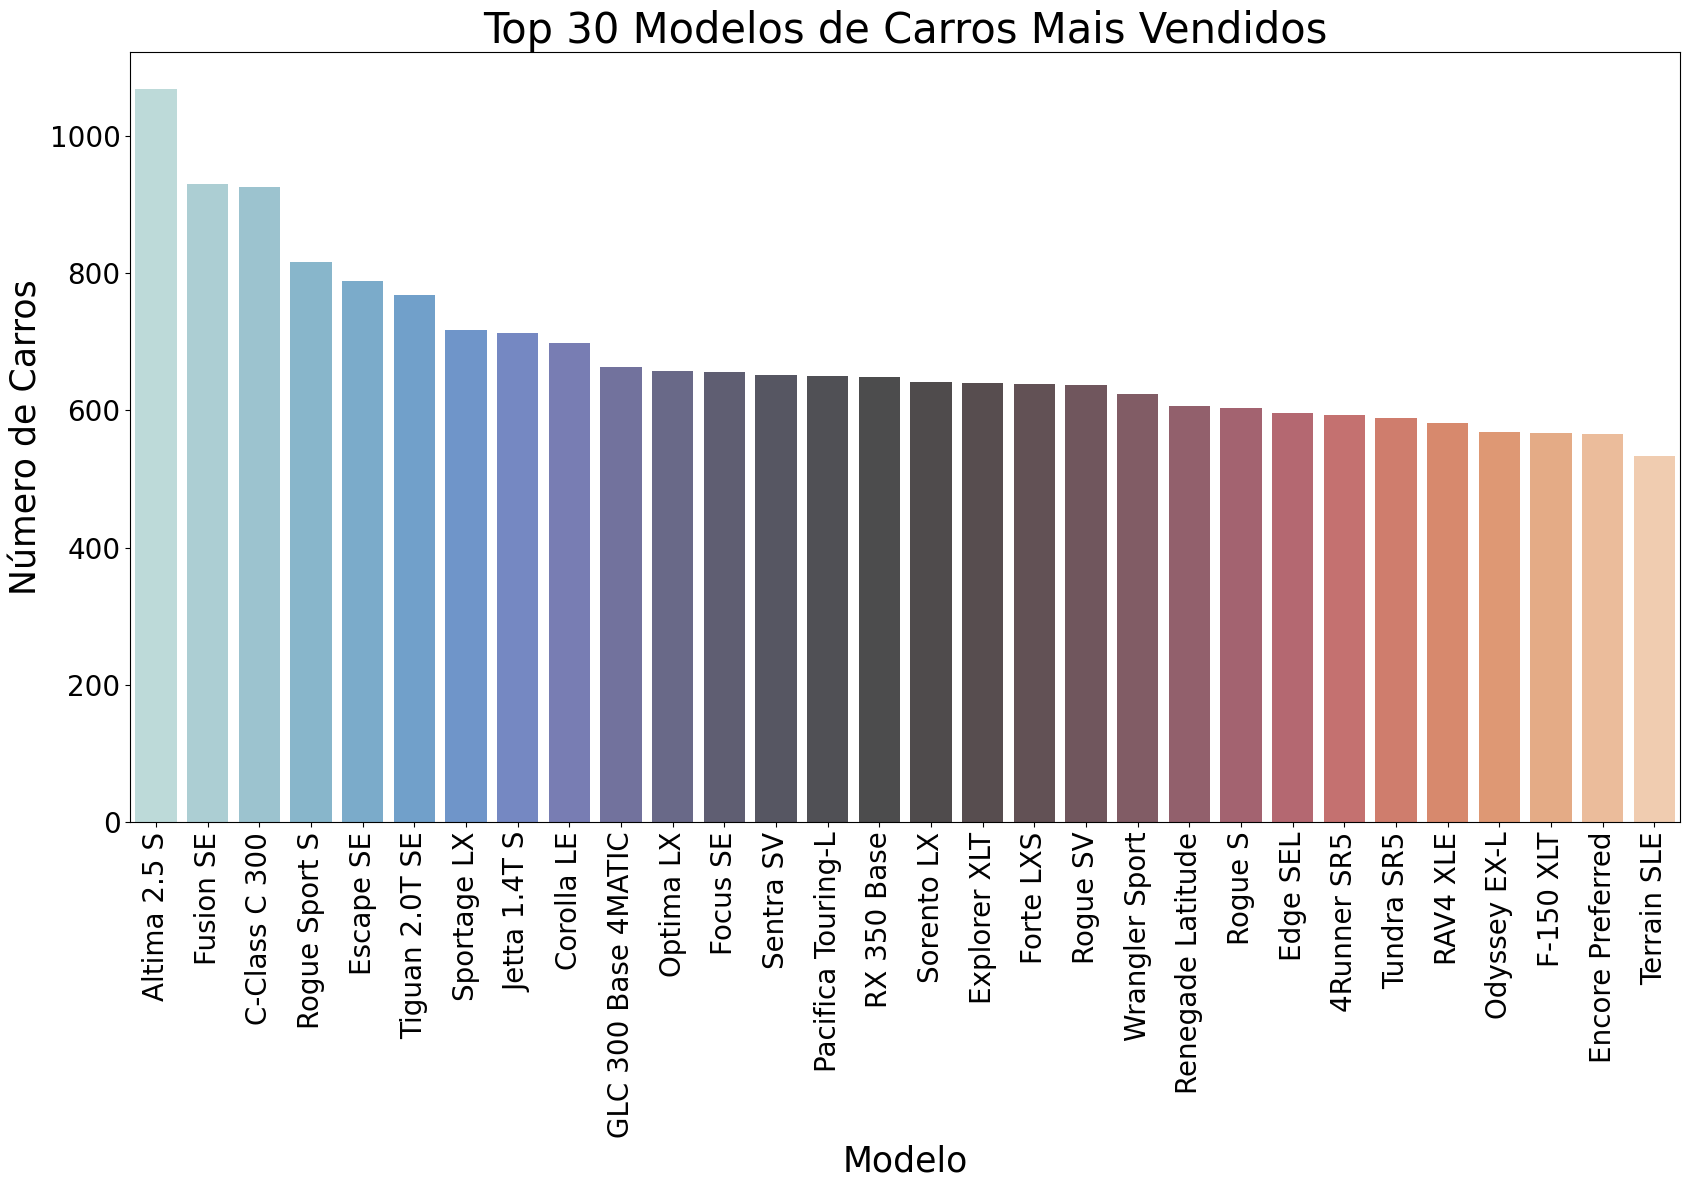

In [23]:
# vamos dar uma olhada nos modelos de carro mais vendidos
top_30_models = cars_df['model'].value_counts().head(30)

# Create a color palette
rainbow_palette = sns.color_palette("icefire", len(top_30_models))

# Plot
plt.figure(figsize=(20, 10))
sns.barplot(x=top_30_models.index, y=top_30_models.values, hue=top_30_models.index, palette=rainbow_palette, alpha=0.8, legend=False)
plt.title('Top 30 Modelos de Carros Mais Vendidos', fontsize=30)
plt.ylabel('Número de Carros', fontsize=25)
plt.xlabel('Modelo', fontsize=25)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## 2.5 Coluna ```year```

In [24]:
cars_df['year'].value_counts()

year
2020    31522
2019    25807
2021    25076
2022    17003
2018    15035
        ...  
1939        1
1948        1
2024        1
1950        1
1915        1
Name: count, Length: 92, dtype: int64

A nossa amostra tem carros de 1915 a 2024. Conforme vimos acima, a relação entre preço e ano é diretamente proporcional.

## 2.6 Coluna ```engine```

In [25]:
cars_df['engine'].value_counts().tail(100)

engine
159.0HP 2.7L 4 Cylinder Engine Gasoline Fuel                        1
4.5L V-8 DOHC, variable valve control, engine with 340HP            1
270.0HP 4.8L 8 Cylinder Engine Gasoline Fuel                        1
3.2L DOHC FSI 24-valve V6 engine                                    1
73.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid                   1
                                                                   ..
Triton 4.6L V-8 engine with 240HP                                   1
3.8L horizontally-opposed DOHC 24V 6-cyl engine-inc: dry sump lu    1
416.0HP 5.6L 8 Cylinder Engine Gasoline Fuel                        1
3.5L 6-Cylinder SMPI DOHC                                           1
177 CID Inline 4 cylinder                                           1
Name: count, Length: 100, dtype: int64

Vamos tentar melhorar a apresentação dos dados em ```engine```. Pensei em extrair os dados usando regex e criar novas colunas a partir dessa. 

In [26]:
def extract_engine_info(engine_str):
    if not isinstance(engine_str, str):
        return pd.Series([None, None, None])

    size_match = re.search(r'(\d+\.\d+)L|(\d+)cc', engine_str, re.IGNORECASE)
    if size_match:
        if size_match.group(1):  # Match para litros
            size = float(size_match.group(1))
        else:  # Match para cc
            size = float(size_match.group(2)) / 1000

        if size > 10.0:
            size /= 10.0  # Divide por 10 se for maior que 10
        elif size > 8.0:  # Trunca para o inteiro mais próximo se for maior que 8
            size = round(size)
        if not (0.6 <= size <= 8.0):  # Verifica se o tamanho está dentro de um intervalo razoável
            size = None
    else:
        size = None

    cyl_match = re.search(r'(\d+) Cylinder|(\d+)Cyl|(\d+)V|(\d+)\s*V|(\d+)-Cylinder|(\d+)-cylinder|(\d+) Cyl|I(\d+)', engine_str, re.IGNORECASE)
    if cyl_match:
        cyl = [group for group in cyl_match.groups() if group is not None][0]
        cylinders = int(cyl)
        # Ajustando valores irrealistas de cilindros
        if cylinders not in [2, 3, 4, 5, 6, 8, 10, 12]:
            if cylinders > 12:
                cylinders = int(str(cylinders)[0])  # Pega o primeiro dígito
            if cylinders == 1:
                cylinders = 4  # Assumir 4 cilindros para 1 (valor irreal)
            elif cylinders % 2 != 0:  # Caso o valor não seja par, ajustar para o mais próximo par razoável
                cylinders = cylinders + 1 if cylinders < 12 else 12
        if cylinders == 0:
            cylinders = None  # Define como None se o número de cilindros for 0 após ajustes
    else:
        cylinders = None
    
    # Verificar se é Turbo (1 = sim, 0 = não)
    turbo = 1 if 'Turbo' in engine_str else 0
    
    return pd.Series([size, cylinders, turbo])

cars_df[['engine_size_L', 'cylinders', 'turbo']] = cars_df['engine'].apply(extract_engine_info)

cars_df

,manufacturer,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,...,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price,model,engine_size_L,cylinders,turbo
499001,Mazda,2015,110208.00,2.5L I4 16V GDI DOHC,6-Speed Manual,FWD,Gasoline,25-37,Soul Red Metallic,Sand,...,AutoNation Toyota Hayward,4.30,4.70,114.00,503.00,14238.00,Mazda6 i Touring,2.50,4.00,0.00
65860,Buick,2015,137000.00,3.6L V6 24V GDI DOHC,6-Speed Automatic,Front-wheel Drive,Gasoline,17-24,Quicksilver Metallic,Light Titanium,...,Alfa Romeo of Minneapolis,4.80,4.60,72.00,502.00,12995.00,Enclave Convenience,3.60,2.00,0.00
191410,Ford,2016,60097.00,2.0L I4 16V GDI DOHC Flexible Fuel,Automatic,Front-wheel Drive,E85 Flex Fuel,26-36,Oxford White,Charcoal Black,...,Bob Rohrman's Indy Hyundai-Genesis,4.60,4.40,193.00,NaN,12444.00,Focus SE,2.00,4.00,0.00
436095,Kia,2016,110444.00,2.0L I4 16V GDI DOHC,6-Speed Automatic,Front-wheel Drive,Gasoline,24-31,Blue,Black,...,Bob Walters Linton Motors,NaN,4.60,337.00,750.00,12995.00,Soul +,2.00,4.00,0.00
576188,Nissan,2015,112652.00,2.5L I4 16V MPFI DOHC,Automatic CVT,All-wheel Drive,Gasoline,25-32,Gun Metallic,Charcoal,...,Jeff Perry Buick GMC,4.60,4.40,263.00,900.00,13512.00,Rogue SV,2.50,4.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268950,Ford,1928,75000.00,NaN,Manual,Rear-wheel Drive,NaN,0-0,Black,Black,...,St. Charles Toyota,4.70,NaN,0.00,1000.00,20995.00,Model A,NaN,NaN,NaN
269786,Ford,1926,0.00,Inline 4,2 speed manual,NaN,NaN,0-0,Black,Gray,...,Gateway Classic Cars,NaN,NaN,0.00,NaN,20000.00,Model T Fordor Sedan,NaN,NaN,0.00
268919,Ford,1929,99999.00,NaN,Manual,NaN,Gasoline,0-0,Green,Black,...,Rte 61 Classics and Toy Barn LLC,NaN,4.70,1.00,NaN,29995.00,Model A Base,NaN,NaN,NaN
268927,Ford,1928,52522.00,NaN,Manual,NaN,NaN,NaN,Yellow,Brown,...,Nick Nicholas Ford,4.90,NaN,0.00,NaN,25968.00,Model A,NaN,NaN,NaN


In [27]:
cars_df['engine_size_L'].isna().sum()

15145

In [28]:
cars_df['cylinders'].isna().sum()

24493

In [29]:
cars_df['turbo'].isna().sum()

3368

Agora precisamos preencher os valores faltantes nas novas colunas. Decidi preencher da seguinte forma:
* o tamanho do motor (```engine_size_L```) pela **média**, uma vez que é um valor contínuo;
* quantidade de cilindros (```cylinders```) será substituída pela **moda**; 
* e turbo (```turbo```) será por **zero**, supondo que muito provavelmente se nada foi preenchido, é porque o carro não possui turbo. 

In [30]:
cars_df['engine_size_L'] = cars_df['engine_size_L'].fillna(cars_df['engine_size_L'].mean())
cars_df['cylinders'] = cars_df['cylinders'].fillna(cars_df['cylinders'].mode()[0])
cars_df['turbo'] = cars_df['turbo'].fillna(0)

In [31]:
cars_df['engine_size_L'].isna().sum()

0

In [32]:
cars_df['cylinders'].isna().sum()

0

In [33]:
cars_df['turbo'].isna().sum()

0

In [34]:
cars_df['engine_size_L'].describe()

count   178533.00
mean         3.03
std          1.25
min          0.65
25%          2.00
50%          3.00
75%          3.60
max          8.00
Name: engine_size_L, dtype: float64

In [35]:
cars_df['cylinders'].describe()

count   178533.00
mean         3.62
std          1.24
min          2.00
25%          2.00
50%          4.00
75%          4.00
max         12.00
Name: cylinders, dtype: float64

In [36]:
cars_df['cylinders'].value_counts()

cylinders
4.00     122518
2.00      45758
6.00       5797
3.00       1840
12.00      1153
8.00       1031
5.00        427
10.00         9
Name: count, dtype: int64

In [37]:
cars_df['turbo'].value_counts()

turbo
0.00    126458
1.00     52075
Name: count, dtype: int64

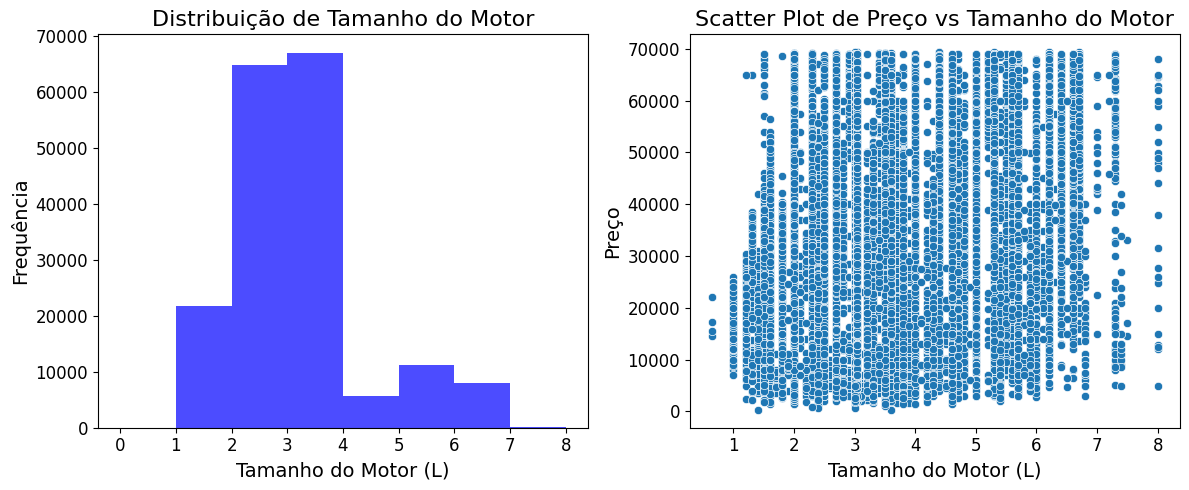

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Primeiro subplot: histograma
ax[0].hist(cars_df['engine_size_L'], bins=range(0, 9), color='blue', alpha=0.7)
ax[0].set_xlabel('Tamanho do Motor (L)', fontsize=14)
ax[0].set_ylabel('Frequência', fontsize=14)
ax[0].set_title('Distribuição de Tamanho do Motor', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=12)

# Segundo subplot: scatter plot
sns.scatterplot(x='engine_size_L', y='price', data=cars_df, ax=ax[1])
ax[1].set_title('Scatter Plot de Preço vs Tamanho do Motor', fontsize=16)
ax[1].set_xlabel('Tamanho do Motor (L)', fontsize=14)
ax[1].set_ylabel('Preço', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

plt.show()

In [39]:
# plt.figure(figsize=(6, 4))
# plt.hist(cars_df['engine_size_L'], bins=(range(0, 9)), color='blue', alpha=0.7)
# plt.xlabel('Tamanho do Motor (L)')
# plt.ylabel('Frequência')
# plt.title('Distribuição de Tamanho do Motor')
# plt.xticks(range(0, 9))
# plt.show()

Podemos ver que a distribuição do tamanho do motor é bimodal, embora uma população seja bem maior que a outra.

O tamanho do motor parece não ser tão decisivo no preço do carro. 

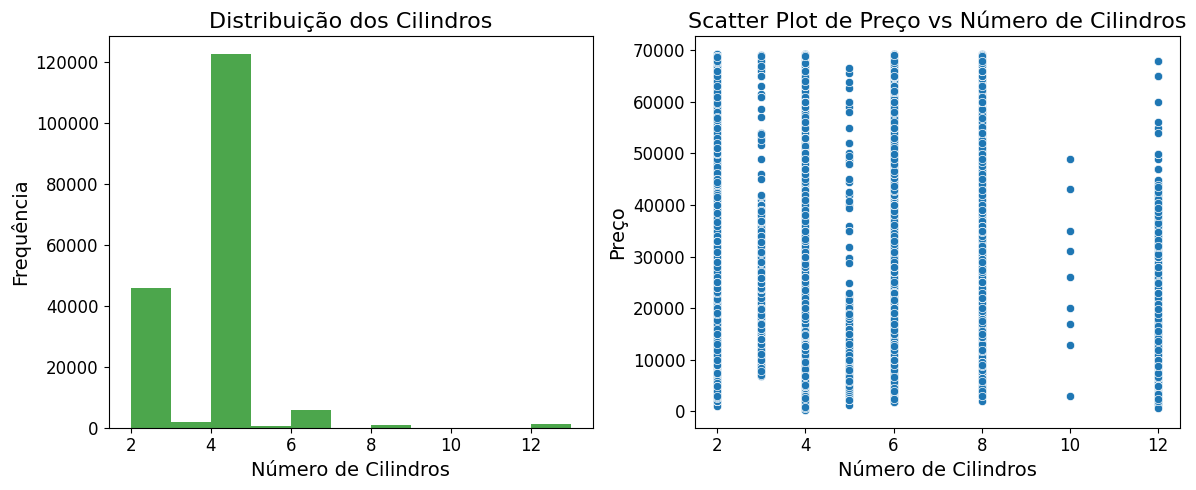

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Primeiro subplot: histograma
ax[0].hist(cars_df['cylinders'], bins=range(2, 14), color='green', alpha=0.7)
ax[0].set_xlabel('Número de Cilindros', fontsize=14)
ax[0].set_ylabel('Frequência', fontsize=14)
ax[0].set_title('Distribuição dos Cilindros', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=12)

# Segundo subplot: scatter plot
sns.scatterplot(x='cylinders', y='price', data=cars_df, ax=ax[1])
ax[1].set_title('Scatter Plot de Preço vs Número de Cilindros', fontsize=16)
ax[1].set_xlabel('Número de Cilindros', fontsize=14)
ax[1].set_ylabel('Preço', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

plt.show()

Podemos ver que a distribuição dos cilindros se concentra principalmente em 4 cilindros. No entanto, a quantidade de cilindros não parece ter um impacto significativo no preço do carro.

In [43]:
# deletando engine
cars_df.drop('engine', axis=1, inplace=True)

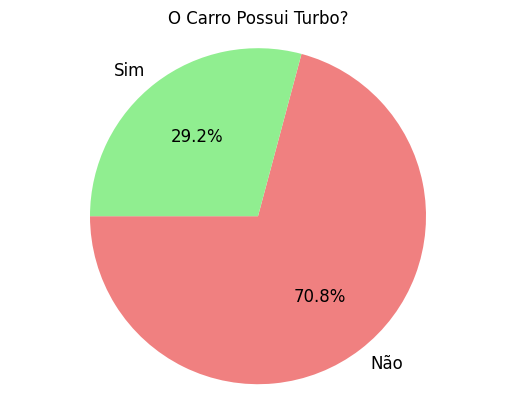

In [44]:
turbo_counts = cars_df['turbo'].value_counts()
plt.pie(turbo_counts, labels=['Não', 'Sim'], colors=['lightcoral', 'lightgreen'], autopct='%1.1f%%', startangle=180, textprops={'fontsize': 12})
plt.axis('equal')
plt.title('O Carro Possui Turbo?')
plt.show()

## 2.7 Coluna ```transmission```

In [45]:
pd.set_option("display.max_rows", 100)
cars_df['transmission'].value_counts()

transmission
6-Speed Automatic                            36019
8-Speed Automatic                            33353
Automatic CVT                                26620
Automatic                                    21783
9-Speed Automatic                            14433
                                             ...  
5-Speed Automatic w/OD                           1
Automatic, 6-Spd w/Overdrive & Sportmatic        1
Tremec 6-Speed Manual                            1
8 Speed Paddle Shift with Automatic Modes        1
2 Speed Manual                                   1
Name: count, Length: 600, dtype: int64

Decidi criar apenas 5 categorias de transmissão para reduzir os valores únicos dessa coluna. De início eram 6, no entanto, apenas um carro ficou na categoria Tiptronic. Assim, achei melhor colocá-lo na categoria ```Other```. 

In [46]:
# criando uma função para lidar com os valores na coluna transmission:
def classify_transmission(transmission):
    patterns = {
        'Manual': r'(Manual|M\/T)\b',
        'Automatic': r'(Automatic|Auto|A\/T|AWD)\b',
        'CVT': r'(CVT|Cvt|Variable Transmission)\b',
        'Semi-Auto': r'(Automatic\s+(?:with\s+)?(Auto-Shift|PowerShift|Geartronic))\b',
        'Dual-Clutch': r'(DCT|Dual Clutch|Dual)\b'
    }
    
    if pd.isnull(transmission): 
        return 'Other' 
    
    for category, pattern in patterns.items():
        if re.search(pattern, transmission, re.IGNORECASE):
            return category
    
    return 'Other' 

# aplicando a função
cars_df['category'] = cars_df['transmission'].apply(classify_transmission)
cars_df['category'].value_counts()

category
Automatic      167670
Manual           5536
Other            3626
CVT              1459
Dual-Clutch       242
Name: count, dtype: int64

In [47]:
# retirando a coluna transmission e renomeando category
cars_df.drop('transmission', axis=1, inplace=True)

cars_df.rename(columns={'category': 'transmission'}, inplace=True)

In [48]:
cars_df.head()

,manufacturer,year,mileage,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,...,seller_rating,driver_rating,driver_reviews_num,price_drop,price,model,engine_size_L,cylinders,turbo,transmission
499001,Mazda,2015,110208.00,FWD,Gasoline,25-37,Soul Red Metallic,Sand,NaN,NaN,...,4.30,4.70,114.00,503.00,14238.00,Mazda6 i Touring,2.50,4.00,0.00,Manual
65860,Buick,2015,137000.00,Front-wheel Drive,Gasoline,17-24,Quicksilver Metallic,Light Titanium,0.00,0.00,...,4.80,4.60,72.00,502.00,12995.00,Enclave Convenience,3.60,2.00,0.00,Automatic
191410,Ford,2016,60097.00,Front-wheel Drive,E85 Flex Fuel,26-36,Oxford White,Charcoal Black,1.00,0.00,...,4.60,4.40,193.00,NaN,12444.00,Focus SE,2.00,4.00,0.00,Automatic
436095,Kia,2016,110444.00,Front-wheel Drive,Gasoline,24-31,Blue,Black,0.00,0.00,...,NaN,4.60,337.00,750.00,12995.00,Soul +,2.00,4.00,0.00,Automatic
576188,Nissan,2015,112652.00,All-wheel Drive,Gasoline,25-32,Gun Metallic,Charcoal,1.00,1.00,...,4.60,4.40,263.00,900.00,13512.00,Rogue SV,2.50,4.00,0.00,Automatic


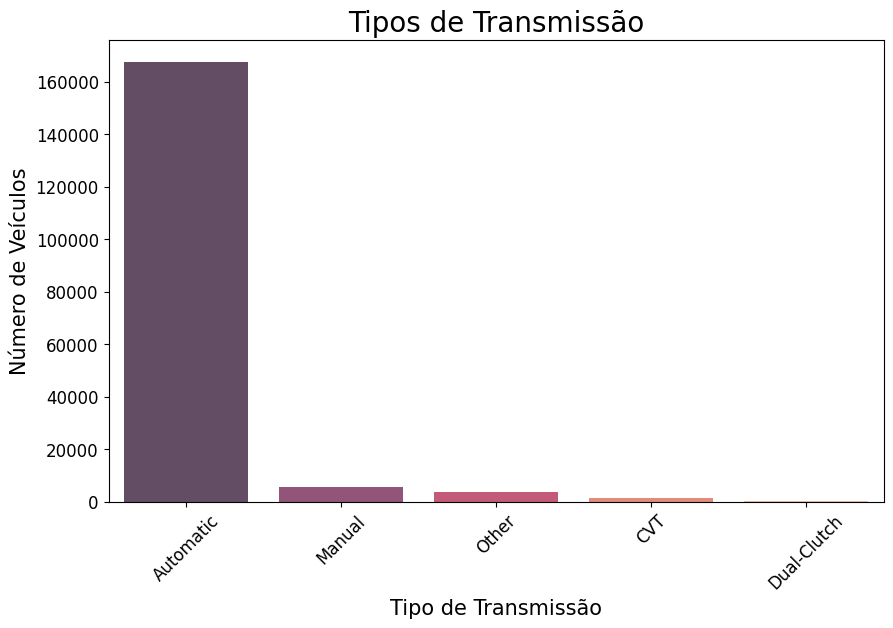

In [49]:
transmission_counts = cars_df['transmission'].value_counts()

rainbow_palette = sns.color_palette("rocket", len(transmission_counts))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=transmission_counts.index, y=transmission_counts.values, hue=transmission_counts.index, palette=rainbow_palette, alpha=0.8)
plt.title('Tipos de Transmissão', fontsize=20)
plt.ylabel('Número de Veículos', fontsize=15)
plt.xlabel('Tipo de Transmissão', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Podemos ver que a transmissão automática é a predominante. Diante da grande disparidade, é possível que essa coluna atrapalhe a nossa previsão de preços.

## 2.8 Coluna ```drivetrain```

Valores únicos de ```drivetrain```:

In [50]:
cars_df['drivetrain'].value_counts()

drivetrain
Front-wheel Drive                                              59200
All-wheel Drive                                                54171
Four-wheel Drive                                               34487
Rear-wheel Drive                                               22439
FWD                                                             1603
AWD                                                              843
4WD                                                              403
RWD                                                              389
Front-Wheel Drive                                                 33
All-Wheel Drive                                                   27
Unknown                                                           26
Four-Wheel Drive with Locking and Limited-Slip Differential       15
Front-Wheel Drive with Limited-Slip Differential                  12
All-Wheel Drive with Locking and Limited-Slip Differential        11
Rear-Wheel Drive       

Valores ```NaN```:

In [51]:
cars_df['drivetrain'].isna().sum()

4834

In [52]:
def classify_drivetrain(drivetrain):
    patterns = {
        'FWD': r'(Front|FWD)\b',
        'AWD': r'(All|AWD)\b',
        '4WD': r'(4x4|Four|4WD)\b',
        'RWD': r'(Rear|4x2|RWD)\b'
    }
    
    if pd.isnull(drivetrain): 
        return 'Other' 
    
    for category, pattern in patterns.items():
        if re.search(pattern, drivetrain, re.IGNORECASE):
            return category
    
    return 'Other' 

# aplicando a função
cars_df['category'] = cars_df['drivetrain'].apply(classify_drivetrain)
cars_df['category'].value_counts()

category
FWD      60854
AWD      55061
4WD      34918
RWD      22839
Other     4861
Name: count, dtype: int64

In [53]:
cars_df.head()

,manufacturer,year,mileage,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,...,driver_rating,driver_reviews_num,price_drop,price,model,engine_size_L,cylinders,turbo,transmission,category
499001,Mazda,2015,110208.00,FWD,Gasoline,25-37,Soul Red Metallic,Sand,NaN,NaN,...,4.70,114.00,503.00,14238.00,Mazda6 i Touring,2.50,4.00,0.00,Manual,FWD
65860,Buick,2015,137000.00,Front-wheel Drive,Gasoline,17-24,Quicksilver Metallic,Light Titanium,0.00,0.00,...,4.60,72.00,502.00,12995.00,Enclave Convenience,3.60,2.00,0.00,Automatic,FWD
191410,Ford,2016,60097.00,Front-wheel Drive,E85 Flex Fuel,26-36,Oxford White,Charcoal Black,1.00,0.00,...,4.40,193.00,NaN,12444.00,Focus SE,2.00,4.00,0.00,Automatic,FWD
436095,Kia,2016,110444.00,Front-wheel Drive,Gasoline,24-31,Blue,Black,0.00,0.00,...,4.60,337.00,750.00,12995.00,Soul +,2.00,4.00,0.00,Automatic,FWD
576188,Nissan,2015,112652.00,All-wheel Drive,Gasoline,25-32,Gun Metallic,Charcoal,1.00,1.00,...,4.40,263.00,900.00,13512.00,Rogue SV,2.50,4.00,0.00,Automatic,AWD


In [54]:
# retirando a coluna drivetrain e renomeando category
cars_df.drop('drivetrain', axis=1, inplace=True)
cars_df.rename(columns={'category': 'drivetrain'}, inplace=True)
cars_df.head()

,manufacturer,year,mileage,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,...,driver_rating,driver_reviews_num,price_drop,price,model,engine_size_L,cylinders,turbo,transmission,drivetrain
499001,Mazda,2015,110208.00,Gasoline,25-37,Soul Red Metallic,Sand,NaN,NaN,NaN,...,4.70,114.00,503.00,14238.00,Mazda6 i Touring,2.50,4.00,0.00,Manual,FWD
65860,Buick,2015,137000.00,Gasoline,17-24,Quicksilver Metallic,Light Titanium,0.00,0.00,1.00,...,4.60,72.00,502.00,12995.00,Enclave Convenience,3.60,2.00,0.00,Automatic,FWD
191410,Ford,2016,60097.00,E85 Flex Fuel,26-36,Oxford White,Charcoal Black,1.00,0.00,1.00,...,4.40,193.00,NaN,12444.00,Focus SE,2.00,4.00,0.00,Automatic,FWD
436095,Kia,2016,110444.00,Gasoline,24-31,Blue,Black,0.00,0.00,0.00,...,4.60,337.00,750.00,12995.00,Soul +,2.00,4.00,0.00,Automatic,FWD
576188,Nissan,2015,112652.00,Gasoline,25-32,Gun Metallic,Charcoal,1.00,1.00,1.00,...,4.40,263.00,900.00,13512.00,Rogue SV,2.50,4.00,0.00,Automatic,AWD


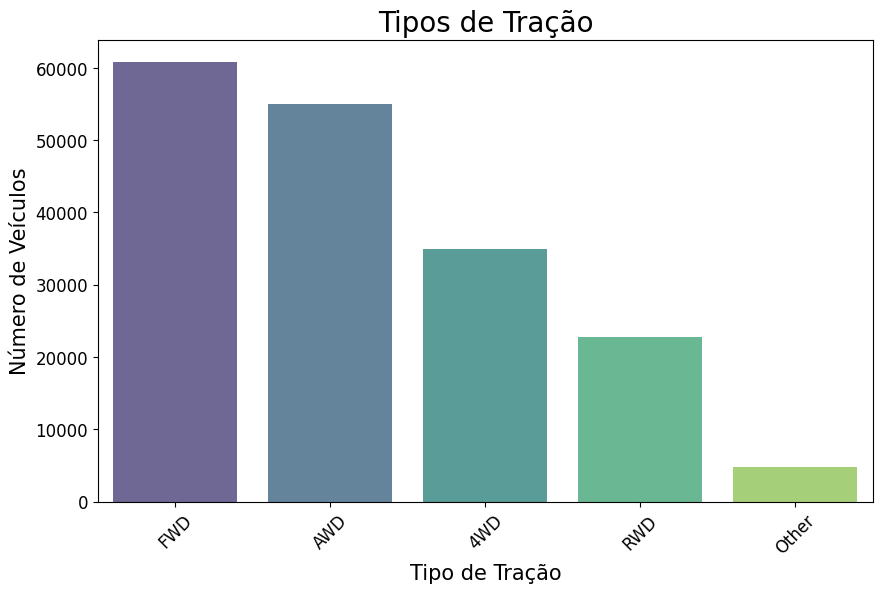

In [55]:
drivetrain_counts = cars_df['drivetrain'].value_counts()

# Paleta de cores
rainbow_palette = sns.color_palette("viridis", len(drivetrain_counts))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=drivetrain_counts.index, y=drivetrain_counts.values, hue=drivetrain_counts.index, palette=rainbow_palette, alpha=0.8)
plt.title('Tipos de Tração', fontsize=20)
plt.ylabel('Número de Veículos', fontsize=15)
plt.xlabel('Tipo de Tração', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 2.9 Coluna ```fuel_type```

In [56]:
cars_df['fuel_type'].value_counts()


fuel_type
Gasoline                         152908
Hybrid                             6764
Diesel                             5134
E85 Flex Fuel                      4405
Electric                           3511
B                                   344
Flexible Fuel                       119
Plug-In Hybrid                       28
Gasoline/Mild Electric Hybrid        21
Gasoline Fuel                        20
Premium Unleaded                     12
G                                    11
Regular Unleaded                     11
Compressed Natural Gas                6
Gaseous                               2
Flex Fuel Capability                  1
Automatic                             1
Diesel Fuel                           1
Biodiesel                             1
E85 Fl                                1
Other                                 1
Gas                                   1
Plug-In Electric/Gas                  1
Unknown                               1
Unspecified                   

Podemos ver algumas categorias repetidas acima. Vamos reduzi-las.

In [57]:
def classify_fuel_type(fuel_type):
    patterns = {
        'Hybrid': r'\b(Hybrid|Plug-In Hybrid|Gasoline/Mild Electric Hybrid|Gas\/Electric Hybrid|PHEV)\b',
        'Gasoline': r'\b(Gasoline|Gas|Regular Unleaded|Premium Unleaded|G)\b',
        'Diesel': r'\b(Diesel|Biodiesel)\b',
        'Flex Fuel': r'\b(E85 Flex Fuel|Flexible Fuel|Flex Fuel Capability)\b',
        'Electric': r'\b(Electric|Electric Fuel System)\b',
        'Natural Gas': r'\b(Compressed Natural Gas|Natural Gas|Gaseous)\b',
        'Hydrogen': r'\b(Hydrogen Fuel Cell)\b'
    }
    
    if pd.isnull(fuel_type): 
        return 'Other' 
    
    for category, pattern in patterns.items():
        if re.search(pattern, fuel_type, re.IGNORECASE):
            return category
    
    return 'Other' 

cars_df['category'] = cars_df['fuel_type'].apply(classify_fuel_type)
cars_df['category'].value_counts()


category
Gasoline       152970
Hybrid           6813
Other            5576
Diesel           5136
Flex Fuel        4525
Electric         3511
Natural Gas         2
Name: count, dtype: int64

E agora, removamos a coluna original:

In [58]:
cars_df.drop('fuel_type', axis=1, inplace=True)
cars_df.rename(columns={'category': 'fuel_type'}, inplace=True)
cars_df.head()

,manufacturer,year,mileage,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,...,driver_reviews_num,price_drop,price,model,engine_size_L,cylinders,turbo,transmission,drivetrain,fuel_type
499001,Mazda,2015,110208.00,25-37,Soul Red Metallic,Sand,NaN,NaN,NaN,AutoNation Toyota Hayward,...,114.00,503.00,14238.00,Mazda6 i Touring,2.50,4.00,0.00,Manual,FWD,Gasoline
65860,Buick,2015,137000.00,17-24,Quicksilver Metallic,Light Titanium,0.00,0.00,1.00,Alfa Romeo of Minneapolis,...,72.00,502.00,12995.00,Enclave Convenience,3.60,2.00,0.00,Automatic,FWD,Gasoline
191410,Ford,2016,60097.00,26-36,Oxford White,Charcoal Black,1.00,0.00,1.00,Bob Rohrman's Indy Hyundai-Genesis,...,193.00,NaN,12444.00,Focus SE,2.00,4.00,0.00,Automatic,FWD,Flex Fuel
436095,Kia,2016,110444.00,24-31,Blue,Black,0.00,0.00,0.00,Bob Walters Linton Motors,...,337.00,750.00,12995.00,Soul +,2.00,4.00,0.00,Automatic,FWD,Gasoline
576188,Nissan,2015,112652.00,25-32,Gun Metallic,Charcoal,1.00,1.00,1.00,Jeff Perry Buick GMC,...,263.00,900.00,13512.00,Rogue SV,2.50,4.00,0.00,Automatic,AWD,Gasoline


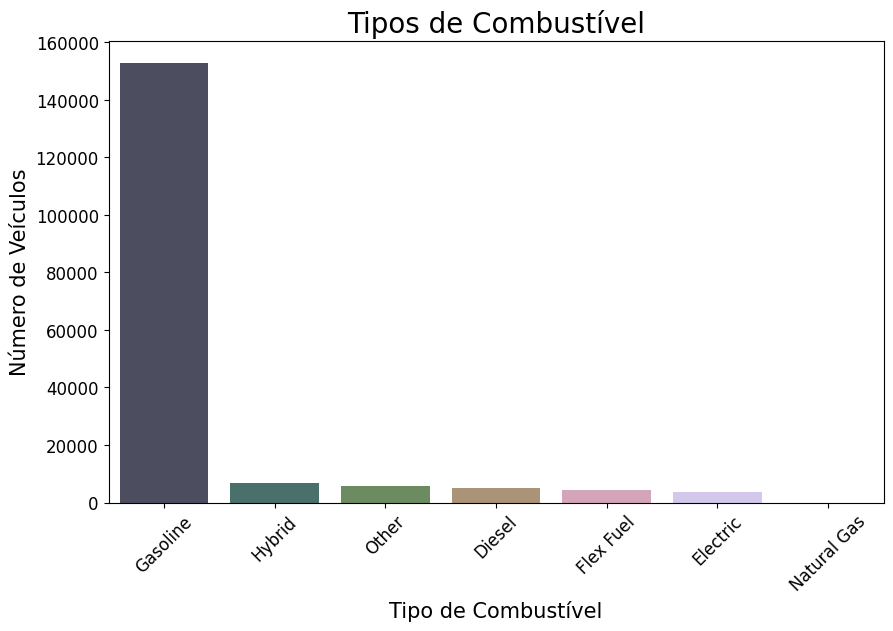

In [59]:
fuel_type_counts = cars_df['fuel_type'].value_counts()

# Paleta de cores
rainbow_palette = sns.color_palette("cubehelix", len(fuel_type_counts))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fuel_type_counts.index, y=fuel_type_counts.values, hue=fuel_type_counts.index, palette=rainbow_palette, alpha=0.8)
plt.title('Tipos de Combustível', fontsize=20)
plt.ylabel('Número de Veículos', fontsize=15)
plt.xlabel('Tipo de Combustível', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Temos também uma quantidade muito grande de carros movidos apenas a gasolina. Essa disparidade pode atrapalhar as previsões.

## 2.10 Coluna ```mpg```

In [60]:
cars_df['mpg'].value_counts()

mpg
19-26      4031
18-25      3962
17-25      3511
20-27      3324
19-28      2740
           ... 
44-43         1
36-39         1
21-27.0       1
18-15         1
10-12         1
Name: count, Length: 636, dtype: int64

Vejamos quantos ```NaN``` há neste dataframe:

In [61]:
cars_df['mpg'].isna().sum()

30465

A estratégia que escolhi para lidar com essa coluna envolveu, primeiramente, transformá-la em númerica, usando as médias dos intervalos representados (ex. as linhas com valor 19-26 ficariam com a média entre os dois números, ou seja, 22,5). Essa medida, no entanto, não foi o suficiente, pois essa coluna possui duas problemáticas: além de ter muitos valores ```NaN```, também possui muitas linhas com valor 0 de milhas por galão, o que claramente são valores irreais.

A primeira solução pensada para esses valores nulos foi preencher essas linhas com a média de mpg do ano do carro. Não deu certo. Todos os anos entre 1923 e 1991 permaneceram ou com ```NaN```, ou com o valor zero, ou ficaram com uma média irreal até para os carros menos ecológicos (ex. 2mpg).

Assim, a estratégia escolhida foi pesquisar a média de mpg dos carros ao longo dos anos e inserir esses dados no dataframe. O estudo usado como referência para esse fim chama-se "On-Road Fuel Economy of Vehicles in the United States: 1923-2015" de Michael Sivak e Brandon Schoettle, publicado pela University of Michigan.


![cars mpg plot](cars-mpg.png)


De acordo com o texto do estudo: os carros foram de 15.3mpg em 1936 a 13.4mpg em 1973, e então subiram para 21.2 em 1991. Vamos seguir essa lógica.

Vamos começar tratando os anos em que temos informações sobre o mpg. Pensei em desfazer a string usando ```split``` e então calcular a média entre os valores. E assim, deixar o valor da média na coluna.

In [62]:
def convert_to_numeric(mpg):
    if isinstance(mpg, str):
        if '-' in mpg:
            parts = mpg.split('-')
            if len(parts) == 2:
                try:
                    start, end = float(parts[0]), float(parts[1])
                    return (start + end) / 2
                except ValueError:
                    return np.nan  
        try:
            return float(mpg)
        except ValueError:
            return np.nan 
    try:
        return float(mpg) # retorna o número caso ele já seja um float
    except ValueError:
        return np.nan

cars_df['mpg_numeric'] = cars_df['mpg'].apply(convert_to_numeric)

Agora é necessário lidar com os valores faltantes. Para calcular a média de mpg por ano, precisamos selecionar apenas as linhas com valores não nulos, para que a média não fique enviesada.

In [63]:
mean_mpg_per_year = cars_df.groupby('year')['mpg_numeric'].mean()
mpg_df = cars_df[(cars_df['mpg_numeric'] != 0.00) & (~cars_df['mpg_numeric'].isna())]
cars_df['mpg_numeric'] = cars_df.apply(lambda row: mean_mpg_per_year[row['year'] - 1] if row['year'] == 2024 and pd.isna(row['mpg_numeric']) else row['mpg_numeric'], axis=1)
mean_mpg_per_year = mpg_df.groupby('year')['mpg_numeric'].mean()

mean_mpg_per_year


year
1979   18.00
1986   15.83
1988   23.00
1989   13.50
1991   15.88
1992   18.69
1993   19.67
1994   19.76
1995   20.01
1996   21.00
1997   20.28
1998   20.96
1999   20.97
2000   20.41
2001   20.89
2002   20.61
2003   20.77
2004   20.62
2005   21.85
2006   22.14
2007   22.67
2008   20.91
2009   22.01
2010   23.20
2011   22.85
2012   23.91
2013   24.79
2014   24.92
2015   25.04
2016   25.09
2017   24.63
2018   25.12
2019   25.26
2020   25.64
2021   25.81
2022   25.92
2023   26.10
Name: mpg_numeric, dtype: float64

In [64]:
manual_means = {
    range(1915, 1941): 15.3,
    range(1941, 1951): 15.0,
    range(1951, 1963): 14.5,
    range(1963, 1966): 14.0,
    range(1966, 1974): 13.4,
    range(1974, 1976): 14.0,
    range(1976, 1979): 14.5,
    range(1979, 1981): 15.0,
    range(1981, 1988): 17.0,
    1990: 15.67,
    2024: 26.10
}

In [65]:
def get_manual_mean(year):
    for year_range, mean in manual_means.items():
        if isinstance(year_range, range):
            if year in year_range:
                return mean
        else:
            if year == year_range:
                return mean
    return None  # Se o ano não estiver nas médias manuais

def replace_with_mean(row, mean_mpg_per_year):
    if row['mpg_numeric'] == 0.00 or pd.isna(row['mpg_numeric']):
        manual_mean = get_manual_mean(row['year'])
        if manual_mean is not None:
            return manual_mean
        return mean_mpg_per_year.get(row['year'], row['mpg_numeric'])  # Manter o valor original se não houver média
    else:
        return row['mpg_numeric']
cars_df['mpg_numeric'] = cars_df.apply(replace_with_mean, axis=1, mean_mpg_per_year=mean_mpg_per_year)

Agora podemos confirmar se há algum dado nulo na coluna ```mpg_numeric```:

In [66]:
cars_df[(cars_df['mpg_numeric'] == 0.00) | (cars_df['mpg_numeric'].isna())]

,manufacturer,year,mileage,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,...,price_drop,price,model,engine_size_L,cylinders,turbo,transmission,drivetrain,fuel_type,mpg_numeric


E agora podemos remover a ```mpg``` orginal e substituí-la pela nova coluna:

In [67]:
cars_df.drop('mpg', axis=1, inplace=True)

cars_df.rename(columns={'mpg_numeric': 'mpg'}, inplace=True)

In [68]:
cars_df.head()

,manufacturer,year,mileage,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,...,price_drop,price,model,engine_size_L,cylinders,turbo,transmission,drivetrain,fuel_type,mpg
499001,Mazda,2015,110208.00,Soul Red Metallic,Sand,NaN,NaN,NaN,AutoNation Toyota Hayward,4.30,...,503.00,14238.00,Mazda6 i Touring,2.50,4.00,0.00,Manual,FWD,Gasoline,31.00
65860,Buick,2015,137000.00,Quicksilver Metallic,Light Titanium,0.00,0.00,1.00,Alfa Romeo of Minneapolis,4.80,...,502.00,12995.00,Enclave Convenience,3.60,2.00,0.00,Automatic,FWD,Gasoline,20.50
191410,Ford,2016,60097.00,Oxford White,Charcoal Black,1.00,0.00,1.00,Bob Rohrman's Indy Hyundai-Genesis,4.60,...,NaN,12444.00,Focus SE,2.00,4.00,0.00,Automatic,FWD,Flex Fuel,31.00
436095,Kia,2016,110444.00,Blue,Black,0.00,0.00,0.00,Bob Walters Linton Motors,NaN,...,750.00,12995.00,Soul +,2.00,4.00,0.00,Automatic,FWD,Gasoline,27.50
576188,Nissan,2015,112652.00,Gun Metallic,Charcoal,1.00,1.00,1.00,Jeff Perry Buick GMC,4.60,...,900.00,13512.00,Rogue SV,2.50,4.00,0.00,Automatic,AWD,Gasoline,28.50


In [69]:
cars_df['mpg'].value_counts()

mpg
23.50    7672
21.50    6804
22.50    6570
24.50    6399
21.00    6012
         ... 
4.50        1
21.75       1
47.75       1
28.75       1
32.80       1
Name: count, Length: 155, dtype: int64

In [70]:
cars_df['mpg'].sort_values()

692356     4.50
117613     5.50
279700     5.50
397684     5.50
154055     5.50
          ...  
15588     77.50
15881     77.50
23120     94.50
23099     94.50
735840   118.50
Name: mpg, Length: 178533, dtype: float64

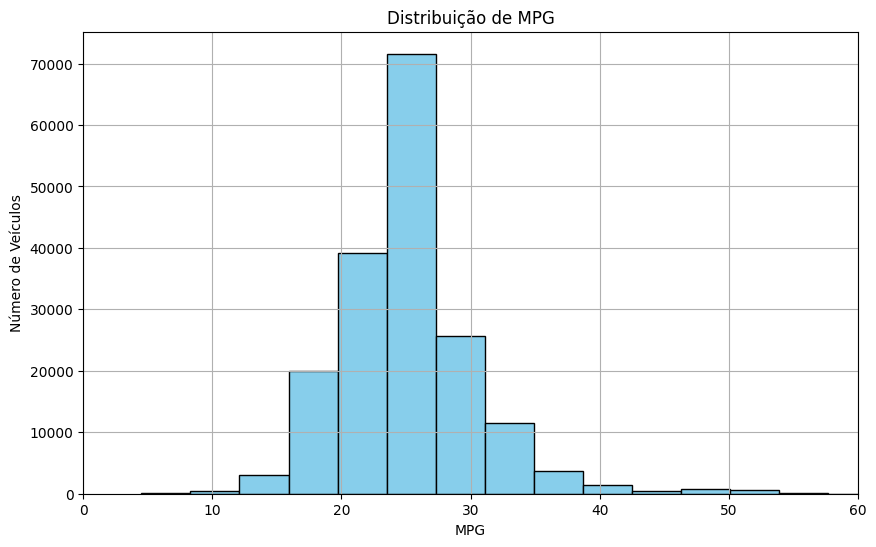

In [71]:
mpg_values = cars_df['mpg']  

plt.figure(figsize=(10, 6))
plt.hist(mpg_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição de MPG')
plt.xlabel('MPG')
plt.ylabel('Número de Veículos')
plt.grid(True)
plt.xlim(0, 60)
plt.show()

Podemos notar que a distribuição dessa coluna é normal, o que pode nos ajudar a prever os preços dos carros.

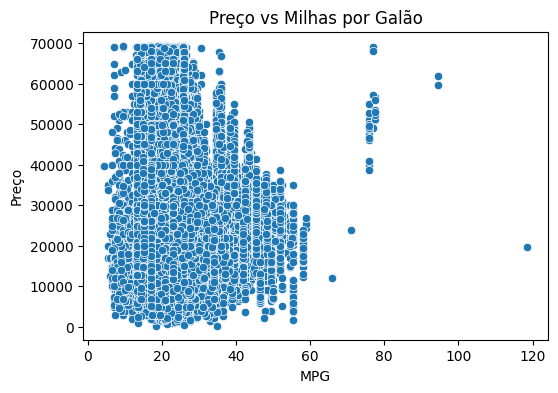

In [72]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='mpg', y='price', data=cars_df)
plt.title('Preço vs Milhas por Galão')
plt.xlabel('MPG')
plt.ylabel('Preço')
plt.show()

Parece haver uma correlação inversa entre ```mpg``` e ```price```. Os consumidores parecem privilegiar carros mais potentes do a carros mais eficientes. No entanto, outros fatores devem ser considerados também de forma que essa não pode ser a nossa conclusão final.

## 2.11 Colunas ```exterior_color```

In [73]:
cars_df['exterior_color'].value_counts()

exterior_color
Black                       13780
White                       11661
Gray                         7326
Silver                       5790
Blue                         4164
                            ...  
Smoke Clearcoat Metallic        1
Winning Blue Metallic           1
Electric Blue Pearl             1
Brick                           1
Lagoon Green                    1
Name: count, Length: 4412, dtype: int64

Precisamos diminuir a quantidade de valores únicos aqui. Vamos começar definindo uma função para lidar com os valores da coluna ```exterior_color```: 

In [74]:
def classify_exterior_color(exterior_color):
    patterns = {
        'Black': r'\b(Black|Ebony|Night|Caviar|Obsidian|Sapphire|BLK|Blac|Rhino|Asphalt|BL|Blackberry)\b',
        'White': r'\b(White|Pearl|Ice|Fresh Powder|Chalk|Rift|Ivory|Iceberg)\b',
        'Gray': r'\b(Gray|Granite|Quartzite|SELENITE|Smoky|Ash|Carbon|MANGANESE|moonstone|Smoke|Cement|Mystic Jade|Steel|Grey|Graphite|Magnetic|Gun|Shadow|Graystone|Pepperdust|Quartz|Iridium|Pewter|Titanium|Charcoal|Tungsten|Lead Foot|Gunmetal|Manhattan Noir)\b',
        'Green': r'\b(Green|Lunar Rock|Jade|Cactus|Olive|Anvil|Moss|Emerald|Sage|Tank|Greenstone|Hypergreen|Lime|Hunter|Mojito|Rainforest|Cypress)\b',
        'Red': r'\b(Red|Maroon|Cherry|Deep Amethyst|Mica|Mahogany|Crimson|Currant|Snazzberry|Ametrin|Velvet|Rosewood|Redline|Scarlet|Burgundy|Infrared|Cinnabar|Sinamon|Torred|Cordovan|Cinnamon|Redfire|Merlot|Rouge|Canyon|Redwood|Ruby|Molten|Garnet|Bordeaux)\b',
        'Blue': r'\b(Blue|Blueprint|DKBLUE|Deep|Water|Azure|Wave|Slate|Blu|Turquoise|Chief Clearcoat|Sky|Denim|Bikini|Teal|Caribbean|Moon Dust|Moondust|Bluestone|Cerulean|AREA 51|Sea|Lunar|Aqua|Nightfall|CELESTITE|Celistite|Frostbite|Storm|Ageha|Atlantic)\b',
        'Orange': r'\b(Orange|Sunset|Mango|Oran|Vitamin C|Lava|Copperhead|Orangeburst)\b',
        'Yellow': r'\b(Yellow|High Velocity|Birch|Hellayella|Alien II)\b',
        'Beige': r'\b(Beige|Sand|Tan|Cream|Sandy|Gobi|Baja|Marshmallow|Khaki|Dune|Quicksand)\b',
        'Brown': r'\b(Brown|espresso|Mocha|Copper|Chocolate|Smoked Mesquite|Bronze|Amber|Caribou|Coffee|Java|Autumn Shimmer)\b',
        'Gold': r'\b(Gold|GLD|Palladium|Savannah|Aruba|Sandstone|Cashmere|Sunstone)\b',
        'Silver': r'\b(Silver|Radiance|Nickel|Quicksilver|Aluminum|Platinum|Metal|Silverstone|Mercury|Billet|Frost|SV|Ceramic|Glacier)\b',
        'Purple': r'\b(Purple|Plum|Hellraisin|Mulberry|Violet|Sangria|Midnight Amethyst)\b',
        'Light Brown': r'\b(Mojave|Brownstone|Pyrite Mica|Coppertino|Bronzemist|Champagne|Gondwana|Stone)\b',
    }
    
    if pd.isnull(exterior_color): 
        return 'Other' 
    
    for category, pattern in patterns.items():
        if re.search(pattern, exterior_color, re.IGNORECASE):
            return category
    
    return 'Other' 

cars_df['category'] = cars_df['exterior_color'].apply(classify_exterior_color)
cars_df['category'].value_counts()


category
White          48986
Black          39332
Gray           30430
Silver         18765
Blue           15663
Red            14872
Other           3512
Green           1928
Brown           1506
Orange           955
Beige            857
Gold             747
Yellow           553
Purple           218
Light Brown      209
Name: count, dtype: int64

In [75]:
cars_df.drop('exterior_color', axis=1, inplace=True)

cars_df.rename(columns={'category': 'exterior_color'}, inplace=True)
cars_df

,manufacturer,year,mileage,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,...,price,model,engine_size_L,cylinders,turbo,transmission,drivetrain,fuel_type,mpg,exterior_color
499001,Mazda,2015,110208.00,Sand,NaN,NaN,NaN,AutoNation Toyota Hayward,4.30,4.70,...,14238.00,Mazda6 i Touring,2.50,4.00,0.00,Manual,FWD,Gasoline,31.00,Red
65860,Buick,2015,137000.00,Light Titanium,0.00,0.00,1.00,Alfa Romeo of Minneapolis,4.80,4.60,...,12995.00,Enclave Convenience,3.60,2.00,0.00,Automatic,FWD,Gasoline,20.50,Silver
191410,Ford,2016,60097.00,Charcoal Black,1.00,0.00,1.00,Bob Rohrman's Indy Hyundai-Genesis,4.60,4.40,...,12444.00,Focus SE,2.00,4.00,0.00,Automatic,FWD,Flex Fuel,31.00,White
436095,Kia,2016,110444.00,Black,0.00,0.00,0.00,Bob Walters Linton Motors,NaN,4.60,...,12995.00,Soul +,2.00,4.00,0.00,Automatic,FWD,Gasoline,27.50,Blue
576188,Nissan,2015,112652.00,Charcoal,1.00,1.00,1.00,Jeff Perry Buick GMC,4.60,4.40,...,13512.00,Rogue SV,2.50,4.00,0.00,Automatic,AWD,Gasoline,28.50,Gray
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268950,Ford,1928,75000.00,Black,0.00,NaN,1.00,St. Charles Toyota,4.70,NaN,...,20995.00,Model A,3.03,4.00,0.00,Manual,RWD,Other,15.30,Black
269786,Ford,1926,0.00,Gray,0.00,NaN,NaN,Gateway Classic Cars,NaN,NaN,...,20000.00,Model T Fordor Sedan,3.03,4.00,0.00,Manual,Other,Other,15.30,Black
268919,Ford,1929,99999.00,Black,0.00,NaN,1.00,Rte 61 Classics and Toy Barn LLC,NaN,4.70,...,29995.00,Model A Base,3.03,4.00,0.00,Manual,Other,Gasoline,15.30,Green
268927,Ford,1928,52522.00,Brown,0.00,NaN,NaN,Nick Nicholas Ford,4.90,NaN,...,25968.00,Model A,3.03,4.00,0.00,Manual,Other,Other,15.30,Yellow


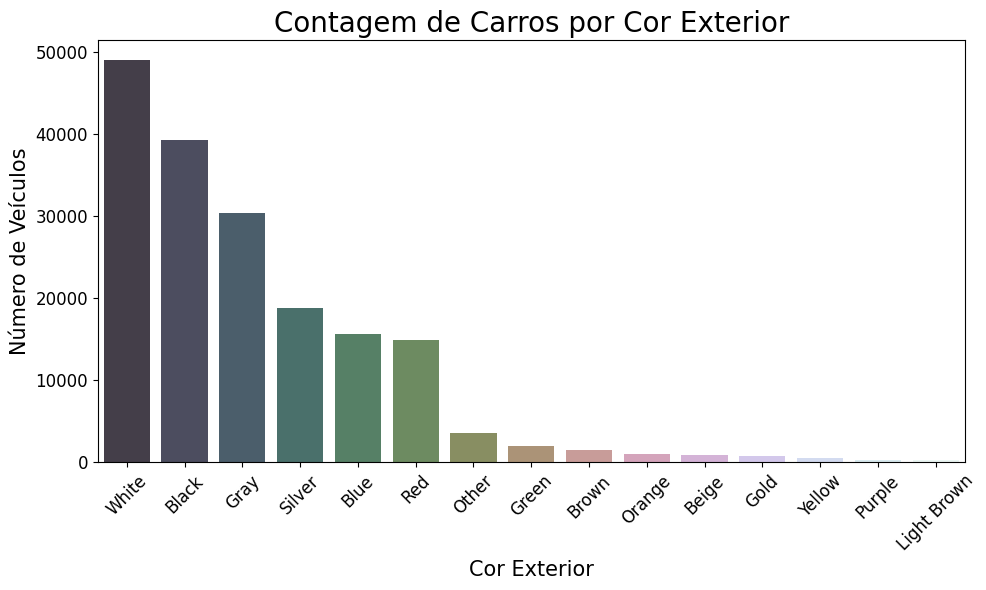

In [76]:
cor_contagens = cars_df['exterior_color'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=cor_contagens.index, y=cor_contagens.values, hue=cor_contagens.index, palette="cubehelix", alpha=0.8)
plt.title('Contagem de Carros por Cor Exterior', fontsize=20)
plt.ylabel('Número de Veículos', fontsize=15)
plt.xlabel('Cor Exterior', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

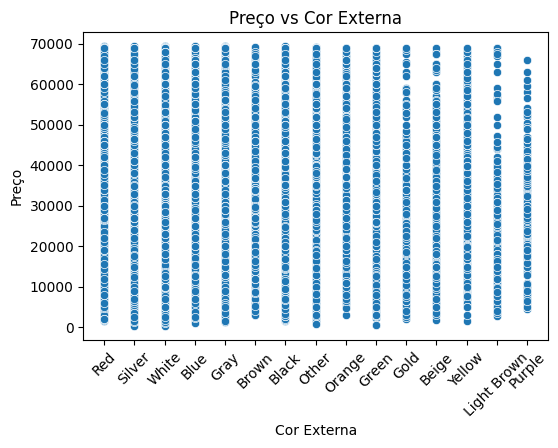

In [77]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='exterior_color', y='price', data=cars_df)
plt.title('Preço vs Cor Externa')
plt.xlabel('Cor Externa')
plt.ylabel('Preço')
plt.xticks(rotation=45, fontsize=10)
plt.show()

Não obstante todo o esforço em sistematizar as cores, parece que não há influência significativa delas nos preços dos carros.

## 2.12 Coluna ```interior_color```

O tratamento para esta coluna será o mesmo que o para a ```exterior_color```, só não usei a mesma função para ambas por uma questão de clareza.

In [78]:
cars_df['interior_color'].value_counts()

interior_color
Black                                  67739
Gray                                   12054
Jet Black                              10204
Ebony                                   8994
Charcoal                                6577
                                       ...  
Salsa Red                                  1
Almond Beige/Mocha                         1
Vintage Tan / Ebony / Ebony Windsor        1
Ebony / Ivory / Ebony / Ivory / Ivo        1
Tan/Green                                  1
Name: count, Length: 2367, dtype: int64

In [79]:
def classify_interior_color(interior_color):
    patterns = {
        'Black': r'\b(Black|Dark|Obsidian|Adobe|Carbon|Midnight|Jet|Anthracite|Ebony|Charcoal|Ebony|Onyx|EA20|Graphite|Graystone|Rock)\b',
        'Gray': r'\b(Gray|Birch|Grey|Charcoal|Tungsten|Sea salt|Graphite|Greystone|Slate|Silver|Platinum|Silverstone|Moonstone|Ash|Cement|Platinum|Graphite|Ash|Light Gray|Steel|Pewter|Cement|Shale|Taupe|Stone|Titanium)\b',
        'Beige': r'\b(Beige|Parchment|Blonde|Latte|Neutral|Cardamom|Champagne|Sandstorm|Cornsilk|Khaki|Oyster|Cirrus|Desert|Ceramic|Ecru|Light Frost|Oyster|Wheat|Sand|Cream|Ivory|Macchiato Beige|Medium Light Stone|Cappuccino|Sandstone|Almond|Acorn|Blond|Cream|Cashmere|Dune|Light Frost|Ivory White|Camel|Bisque|Medium Light Ceramic|Flaxen|Chateau|Light Oyster|Light Putty|Macadamia|Heritage Tan|Toffee|Light Slate|Cirrus)\b',
        'Brown': r'\b(Brown|Tan|Terra|Cafe|Macchiato|Oak|Tupelo|Truffle|Walnut|Caraway|Sepia|Pecan|Teak|Brownstone|Cognac|Saddle|Mocha|Cocoa|Choccachino|Earth|Espresso|Dark Walnut|Java|Caramel|Amber|Coffee|Chestnut|Medium Dark Slate|Gideon|Maple Sugar|Medium Flint|Russet|Nutmeg|Tartufo|Deep Chestnut|Auburn|Amarone|Roast|Cinnamon|Terracotta|Ginger|Brandy|Dark Auburn|Hazelnut|Kalahari)\b',
        'Red': r'\b(Red|Ruby Red|Rioja Red|Burgundy|Redwood|Maroon|Mahogany|Sangria)\b',
        'Blue': r'\b(Blue|Navy Pier|Navy|Indigo|Turquoise)\b',
        'White': r'\b(White)\b',
        'Green': r'\b(Green|Ivy|Deep Cypress|Sage)\b',
        'Orange': r'\b(Orange)\b',
    }
    
    if pd.isnull(interior_color): 
        return 'Other' 
    
    for category, pattern in patterns.items():
        if re.search(pattern, interior_color, re.IGNORECASE):
            return category
    
    return 'Other' 

cars_df['category'] = cars_df['interior_color'].apply(classify_interior_color)
cars_df['category'].value_counts()

category
Black     117984
Gray       20227
Other      15162
Beige      14829
Brown       7559
Red         1813
White        453
Blue         390
Orange        59
Green         57
Name: count, dtype: int64

In [80]:
cars_df.drop('interior_color', axis=1, inplace=True)

cars_df.rename(columns={'category': 'interior_color'}, inplace=True)
cars_df

,manufacturer,year,mileage,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,...,model,engine_size_L,cylinders,turbo,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color
499001,Mazda,2015,110208.00,NaN,NaN,NaN,AutoNation Toyota Hayward,4.30,4.70,114.00,...,Mazda6 i Touring,2.50,4.00,0.00,Manual,FWD,Gasoline,31.00,Red,Beige
65860,Buick,2015,137000.00,0.00,0.00,1.00,Alfa Romeo of Minneapolis,4.80,4.60,72.00,...,Enclave Convenience,3.60,2.00,0.00,Automatic,FWD,Gasoline,20.50,Silver,Gray
191410,Ford,2016,60097.00,1.00,0.00,1.00,Bob Rohrman's Indy Hyundai-Genesis,4.60,4.40,193.00,...,Focus SE,2.00,4.00,0.00,Automatic,FWD,Flex Fuel,31.00,White,Black
436095,Kia,2016,110444.00,0.00,0.00,0.00,Bob Walters Linton Motors,NaN,4.60,337.00,...,Soul +,2.00,4.00,0.00,Automatic,FWD,Gasoline,27.50,Blue,Black
576188,Nissan,2015,112652.00,1.00,1.00,1.00,Jeff Perry Buick GMC,4.60,4.40,263.00,...,Rogue SV,2.50,4.00,0.00,Automatic,AWD,Gasoline,28.50,Gray,Black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268950,Ford,1928,75000.00,0.00,NaN,1.00,St. Charles Toyota,4.70,NaN,0.00,...,Model A,3.03,4.00,0.00,Manual,RWD,Other,15.30,Black,Black
269786,Ford,1926,0.00,0.00,NaN,NaN,Gateway Classic Cars,NaN,NaN,0.00,...,Model T Fordor Sedan,3.03,4.00,0.00,Manual,Other,Other,15.30,Black,Gray
268919,Ford,1929,99999.00,0.00,NaN,1.00,Rte 61 Classics and Toy Barn LLC,NaN,4.70,1.00,...,Model A Base,3.03,4.00,0.00,Manual,Other,Gasoline,15.30,Green,Black
268927,Ford,1928,52522.00,0.00,NaN,NaN,Nick Nicholas Ford,4.90,NaN,0.00,...,Model A,3.03,4.00,0.00,Manual,Other,Other,15.30,Yellow,Brown


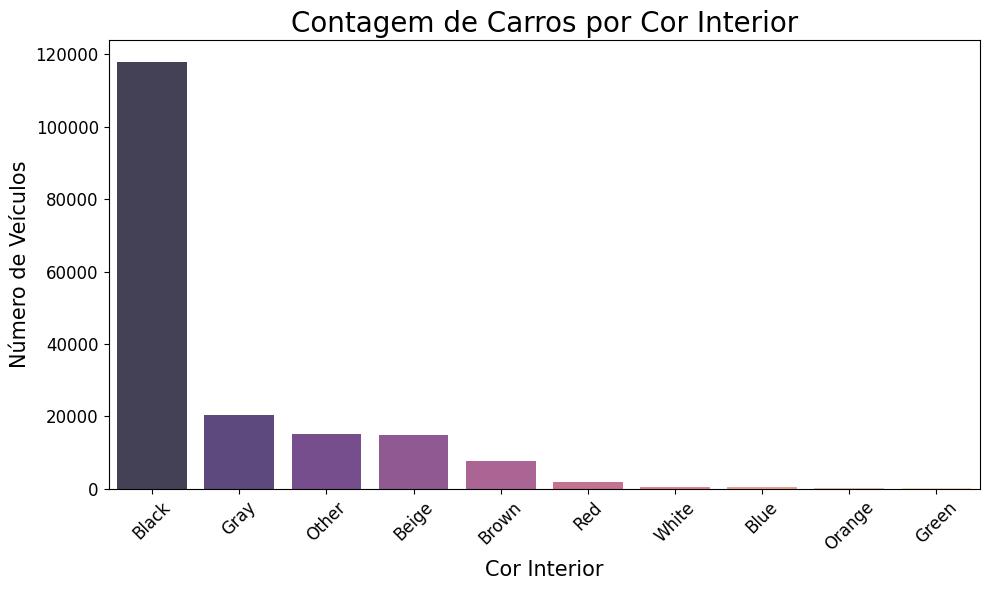

In [81]:
cor_int_contagens = cars_df['interior_color'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=cor_int_contagens.index, y=cor_int_contagens.values, hue=cor_int_contagens.index, palette="magma", alpha=0.8)
plt.title('Contagem de Carros por Cor Interior', fontsize=20)
plt.ylabel('Número de Veículos', fontsize=15)
plt.xlabel('Cor Interior', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

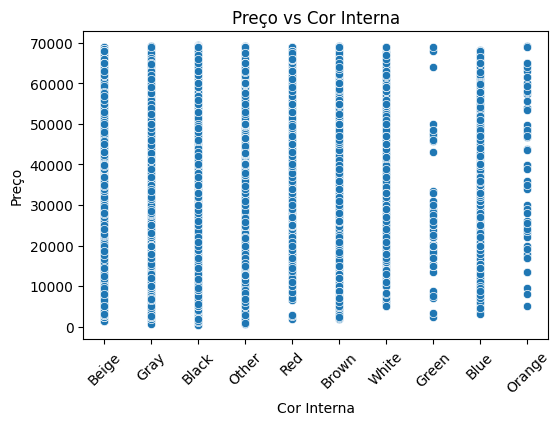

In [82]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='interior_color', y='price', data=cars_df)
plt.title('Preço vs Cor Interna')
plt.xlabel('Cor Interna')
plt.ylabel('Preço')
plt.xticks(rotation=45, fontsize=10)
plt.show()

Da mesma forma que em ```exterior_color```, parece não haver influência significativa dessa variável em preço.

## 2.13 Coluna ```accidents_or_damage```

In [83]:
cars_df['accidents_or_damage'].value_counts()

accidents_or_damage
0.00    132350
1.00     40619
Name: count, dtype: int64

In [84]:
cars_df['accidents_or_damage'].isna().sum()

5564

Não vejo muita opção nesse caso, a não ser considerar como zero os valores nulos. O primeiro e principal motivo é que a própria amostra já sugere que há maiores chances de um carro nesse dataframe não ter sofrido acidentes. Segundo, porque é fato corriqueiro que, ao preencher cadastros, as pessoas apenas preencham valores que saiam da normalidade. Assim, é mais provável que quem preencheu as informações tenha deixado o campo em branco, uma vez que não havia anotação de acidentes a ser feita. E terceiro, por uma razão operacional: ainda que tenha sido preenchido com zero, é também bastante compreensível que algum computador tenha entendido o zero como nulo. Assim, vamos substituir os valores ```NaN``` por 0.

In [85]:
cars_df['accidents_or_damage'] = cars_df['accidents_or_damage'].fillna(0)

In [86]:
cars_df['accidents_or_damage'].value_counts()

accidents_or_damage
0.00    137914
1.00     40619
Name: count, dtype: int64

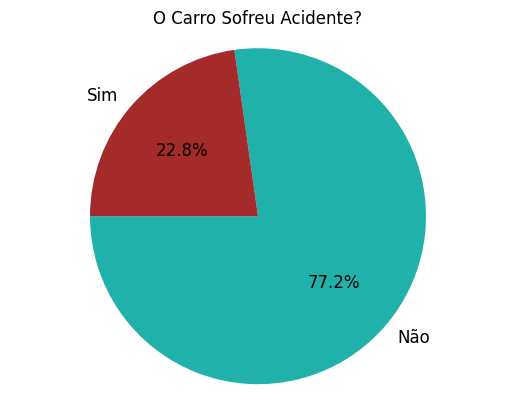

In [87]:
accidents_counts = cars_df['accidents_or_damage'].value_counts()
plt.pie(accidents_counts, labels=['Não', 'Sim'], colors=['lightseagreen', 'brown'], autopct='%1.1f%%', startangle=180, textprops={'fontsize': 12})
plt.axis('equal')
plt.title('O Carro Sofreu Acidente?')
plt.show()

## 2.14 Coluna ```one_owner```

In [88]:
cars_df['one_owner'].value_counts()

one_owner
1.00    95615
0.00    75894
Name: count, dtype: int64

In [89]:
cars_df['one_owner'].isna().sum()

7024

Diante da grande quantidade de valores nulos e o fato de que agora a amostra maior é a de número um, achei mais sensato dividir o preenchimento dos valores nulos de forma a manter a proporção da amostra.

In [90]:
proportions = cars_df['one_owner'].value_counts(normalize=True)
cars_df['one_owner_proportional'] = cars_df['one_owner'].apply(
    lambda x: np.random.choice([0, 1], p=[proportions[0], proportions[1]]) if pd.isna(x) else x
)

In [91]:
cars_df['one_owner_proportional'].isna().sum()

0

E apenas para demonstrar que a proporção continua a mesma, abaixo podemos ver os plots com as proporções antes e depois do processamento.

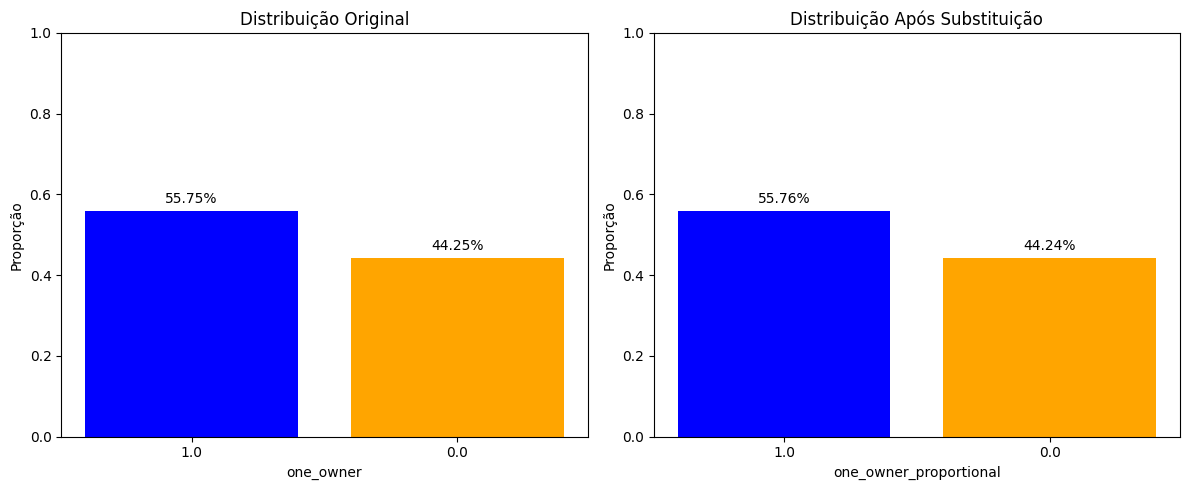

In [92]:
new_distribution = cars_df['one_owner_proportional'].value_counts(normalize=True)

# Plotando as distribuições
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

original_distribution = proportions
ax[0].bar(original_distribution.index.astype(str), original_distribution, color=['blue', 'orange'])
ax[0].set_title('Distribuição Original')
ax[0].set_xlabel('one_owner')
ax[0].set_ylabel('Proporção')
ax[0].set_ylim(0, 1)
for i, v in enumerate(original_distribution):
    ax[0].text(i, v + 0.02, f'{v:.2%}', ha='center')

ax[1].bar(new_distribution.index.astype(str), new_distribution, color=['blue', 'orange'])
ax[1].set_title('Distribuição Após Substituição')
ax[1].set_xlabel('one_owner_proportional')
ax[1].set_ylabel('Proporção')
ax[1].set_ylim(0, 1)
for i, v in enumerate(new_distribution):
    ax[1].text(i, v + 0.02, f'{v:.2%}', ha='center')

plt.tight_layout()
plt.show()

In [93]:
# agora podemos deletar one_owner

cars_df.drop('one_owner', axis=1, inplace=True)

cars_df.rename(columns={'one_owner_proportional': 'one_owner'}, inplace=True)
cars_df

,manufacturer,year,mileage,accidents_or_damage,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,...,engine_size_L,cylinders,turbo,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,one_owner
499001,Mazda,2015,110208.00,0.00,NaN,AutoNation Toyota Hayward,4.30,4.70,114.00,503.00,...,2.50,4.00,0.00,Manual,FWD,Gasoline,31.00,Red,Beige,0.00
65860,Buick,2015,137000.00,0.00,1.00,Alfa Romeo of Minneapolis,4.80,4.60,72.00,502.00,...,3.60,2.00,0.00,Automatic,FWD,Gasoline,20.50,Silver,Gray,0.00
191410,Ford,2016,60097.00,1.00,1.00,Bob Rohrman's Indy Hyundai-Genesis,4.60,4.40,193.00,NaN,...,2.00,4.00,0.00,Automatic,FWD,Flex Fuel,31.00,White,Black,0.00
436095,Kia,2016,110444.00,0.00,0.00,Bob Walters Linton Motors,NaN,4.60,337.00,750.00,...,2.00,4.00,0.00,Automatic,FWD,Gasoline,27.50,Blue,Black,0.00
576188,Nissan,2015,112652.00,1.00,1.00,Jeff Perry Buick GMC,4.60,4.40,263.00,900.00,...,2.50,4.00,0.00,Automatic,AWD,Gasoline,28.50,Gray,Black,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268950,Ford,1928,75000.00,0.00,1.00,St. Charles Toyota,4.70,NaN,0.00,1000.00,...,3.03,4.00,0.00,Manual,RWD,Other,15.30,Black,Black,0.00
269786,Ford,1926,0.00,0.00,NaN,Gateway Classic Cars,NaN,NaN,0.00,NaN,...,3.03,4.00,0.00,Manual,Other,Other,15.30,Black,Gray,1.00
268919,Ford,1929,99999.00,0.00,1.00,Rte 61 Classics and Toy Barn LLC,NaN,4.70,1.00,NaN,...,3.03,4.00,0.00,Manual,Other,Gasoline,15.30,Green,Black,1.00
268927,Ford,1928,52522.00,0.00,NaN,Nick Nicholas Ford,4.90,NaN,0.00,NaN,...,3.03,4.00,0.00,Manual,Other,Other,15.30,Yellow,Brown,0.00


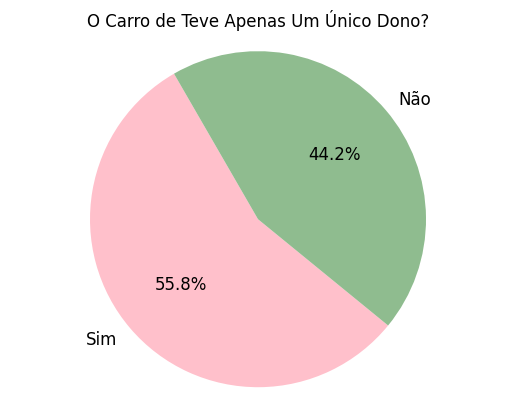

In [94]:
owner_counts = cars_df['one_owner'].value_counts()
plt.pie(owner_counts, labels=['Sim', 'Não'], colors=['pink', 'darkseagreen'], autopct='%1.1f%%', startangle=120, textprops={'fontsize': 12})
plt.axis('equal')
plt.title('O Carro de Teve Apenas Um Único Dono?')
plt.show()

## 2.15 Coluna ```personal_use_only```

In [95]:
cars_df['personal_use_only'].value_counts()

personal_use_only
1.00    113118
0.00     59722
Name: count, dtype: int64

In [96]:
cars_df['personal_use_only'].isna().sum()

5693

Vamos usar a mesma estratégia usada na última coluna.

In [97]:
proportions_personal_use = cars_df['personal_use_only'].value_counts(normalize=True)
cars_df['puo_proportional'] = cars_df['personal_use_only'].apply(
    lambda x: np.random.choice([0, 1], p=[proportions_personal_use[0], proportions_personal_use[1]]) if pd.isna(x) else x
)

In [98]:
cars_df['puo_proportional'].isna().sum()

0

E apenas para confirmar a correspondência de proporções antes e depois da substituição dos valores nulos:

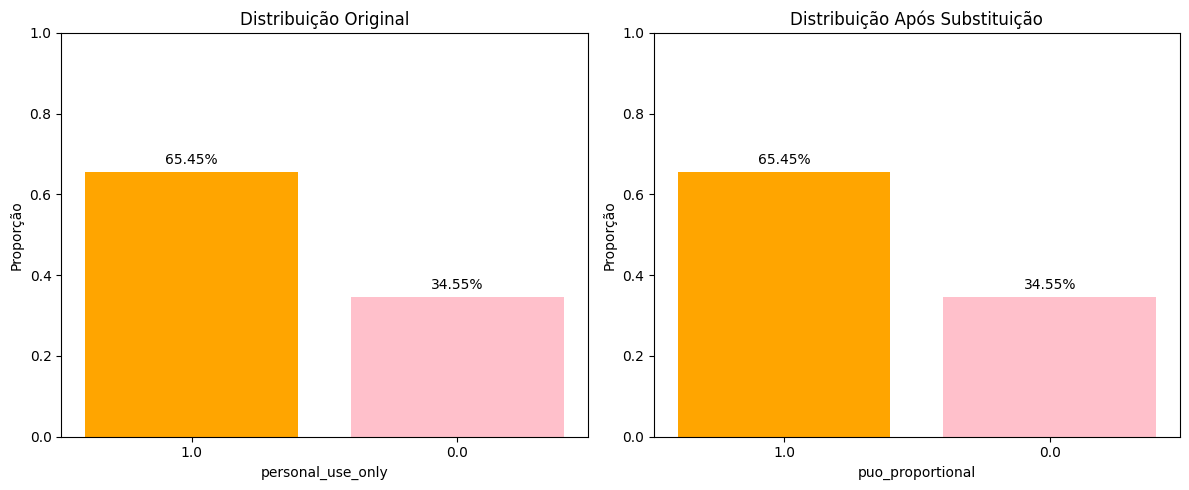

In [99]:
new_distribution2 = cars_df['puo_proportional'].value_counts(normalize=True)

# Plotando as distribuições
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

original_distribution2 = proportions_personal_use
ax[0].bar(original_distribution2.index.astype(str), original_distribution2, color=['orange', 'pink'])
ax[0].set_title('Distribuição Original')
ax[0].set_xlabel('personal_use_only')
ax[0].set_ylabel('Proporção')
ax[0].set_ylim(0, 1)
for i, v in enumerate(original_distribution2):
    ax[0].text(i, v + 0.02, f'{v:.2%}', ha='center')

ax[1].bar(new_distribution2.index.astype(str), new_distribution2, color=['orange', 'pink'])
ax[1].set_title('Distribuição Após Substituição')
ax[1].set_xlabel('puo_proportional')
ax[1].set_ylabel('Proporção')
ax[1].set_ylim(0, 1)
for i, v in enumerate(new_distribution2):
    ax[1].text(i, v + 0.02, f'{v:.2%}', ha='center')

plt.tight_layout()
plt.show()

In [100]:
# deletando personal_use_only

cars_df.drop('personal_use_only', axis=1, inplace=True)

cars_df.rename(columns={'puo_proportional': 'personal_use_only'}, inplace=True)
cars_df

,manufacturer,year,mileage,accidents_or_damage,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price,...,cylinders,turbo,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,one_owner,personal_use_only
499001,Mazda,2015,110208.00,0.00,AutoNation Toyota Hayward,4.30,4.70,114.00,503.00,14238.00,...,4.00,0.00,Manual,FWD,Gasoline,31.00,Red,Beige,0.00,0.00
65860,Buick,2015,137000.00,0.00,Alfa Romeo of Minneapolis,4.80,4.60,72.00,502.00,12995.00,...,2.00,0.00,Automatic,FWD,Gasoline,20.50,Silver,Gray,0.00,1.00
191410,Ford,2016,60097.00,1.00,Bob Rohrman's Indy Hyundai-Genesis,4.60,4.40,193.00,NaN,12444.00,...,4.00,0.00,Automatic,FWD,Flex Fuel,31.00,White,Black,0.00,1.00
436095,Kia,2016,110444.00,0.00,Bob Walters Linton Motors,NaN,4.60,337.00,750.00,12995.00,...,4.00,0.00,Automatic,FWD,Gasoline,27.50,Blue,Black,0.00,0.00
576188,Nissan,2015,112652.00,1.00,Jeff Perry Buick GMC,4.60,4.40,263.00,900.00,13512.00,...,4.00,0.00,Automatic,AWD,Gasoline,28.50,Gray,Black,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268950,Ford,1928,75000.00,0.00,St. Charles Toyota,4.70,NaN,0.00,1000.00,20995.00,...,4.00,0.00,Manual,RWD,Other,15.30,Black,Black,0.00,1.00
269786,Ford,1926,0.00,0.00,Gateway Classic Cars,NaN,NaN,0.00,NaN,20000.00,...,4.00,0.00,Manual,Other,Other,15.30,Black,Gray,1.00,0.00
268919,Ford,1929,99999.00,0.00,Rte 61 Classics and Toy Barn LLC,NaN,4.70,1.00,NaN,29995.00,...,4.00,0.00,Manual,Other,Gasoline,15.30,Green,Black,1.00,1.00
268927,Ford,1928,52522.00,0.00,Nick Nicholas Ford,4.90,NaN,0.00,NaN,25968.00,...,4.00,0.00,Manual,Other,Other,15.30,Yellow,Brown,0.00,0.00


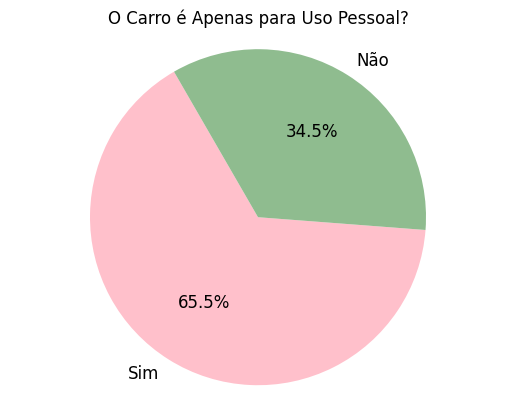

In [101]:
personal_use_counts = cars_df['personal_use_only'].value_counts()
plt.pie(personal_use_counts, labels=['Sim', 'Não'], colors=['pink', 'darkseagreen'], autopct='%1.1f%%', startangle=120, textprops={'fontsize': 12})
plt.axis('equal')
plt.title('O Carro é Apenas para Uso Pessoal?')
plt.show()

## 2.16 Colunas ```seller_name``` e ```seller_rating```

Certamente o nome do vendedor não influencia para nada no preço da venda dos carros. Assim, essa coluna deverá ser apagada.

In [102]:
cars_df.drop('seller_name', axis=1, inplace=True)

Resta saber se há relação entre a avaliação do vendedor e o preço de venda.

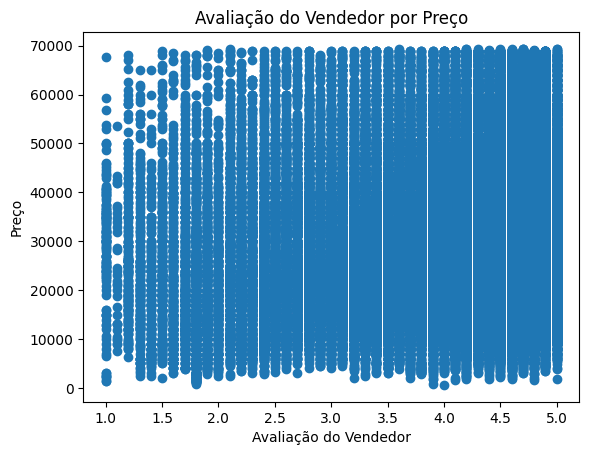

In [103]:
plt.scatter(cars_df['seller_rating'], cars_df['price'])
plt.title('Avaliação do Vendedor por Preço')
plt.ylabel('Preço')
plt.xlabel('Avaliação do Vendedor')
plt.show()

Parece que há uma relação, mas muito tímida, indicando que quanto melhor a avaliação, maiores as chances de vender por um preço mais alto.

In [104]:
cars_df['seller_rating'].isna().sum()

50514

Vamos substituir os valores faltantes pela média.

In [105]:
mean_seller_rating = cars_df['seller_rating'].mean()

cars_df['seller_rating'] = cars_df['seller_rating'].fillna(mean_seller_rating)


In [106]:
mean_seller_rating

4.158398362743031

## 2.17 Coluna ```driver_reviews_num```

In [107]:
cars_df['driver_reviews_num'].value_counts()

driver_reviews_num
0.00      5024
2.00      4126
4.00      3692
3.00      3608
10.00     2880
          ... 
301.00      15
369.00      15
232.00      13
240.00      13
209.00      10
Name: count, Length: 369, dtype: int64

Parece haver uma relação entre o número de avaliações entre os carros e o preço pelo qual são vendidos. 

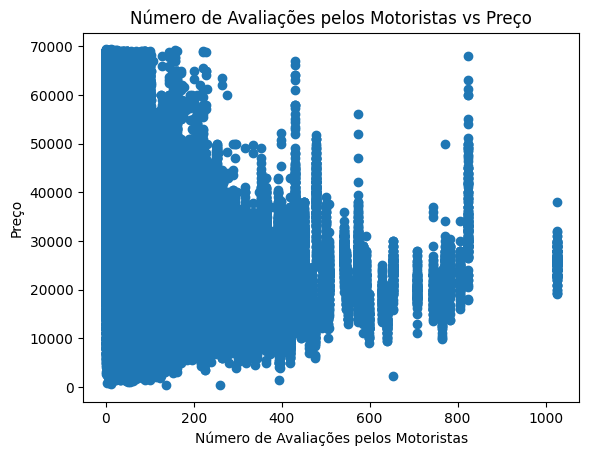

In [108]:
plt.scatter(cars_df['driver_reviews_num'], cars_df['price'])
plt.title('Número de Avaliações pelos Motoristas vs Preço')
plt.ylabel('Preço')
plt.xlabel('Número de Avaliações pelos Motoristas')
plt.show()

Curiosamente, o plot indica uma correlação inversa entre quantidade de avaliações dos carros pelos motoristas e preço. Isso pode se dever a alguns fatores, entre eles:
* carros menos avaliados geralmente são mais novos, o que os torna mais caros; e
* carros menos avaliados podem ser mais raros, e portanto, mais caros.

## 2.18 Coluna ```driver_rating```

In [109]:
cars_df['driver_rating'].value_counts()

driver_rating
4.70    38612
4.80    37705
4.60    28504
4.50    17747
4.90    14974
4.40     9789
4.30     6823
5.00     6584
4.20     4018
4.10     3141
4.00     1608
3.80     1173
3.90      899
3.70      524
3.40      367
3.60      317
2.90      173
3.50      146
2.60       88
2.80       84
3.00       78
1.00       52
3.20       40
2.50       25
3.30       17
2.70        8
2.20        5
3.10        4
2.10        3
2.00        1
Name: count, dtype: int64

In [110]:
cars_df['driver_rating'].isna().sum()

5024

Vamos avaliar como podemos substituir os valores ```NaN```.

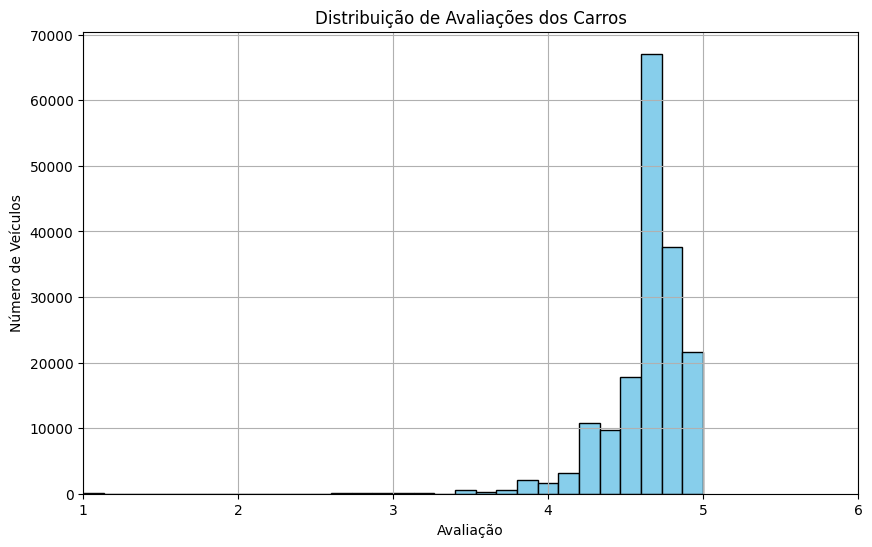

In [111]:
driver_rat_values = cars_df['driver_rating']  

plt.figure(figsize=(10, 6))
plt.hist(driver_rat_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição de Avaliações dos Carros')
plt.xlabel('Avaliação')
plt.ylabel('Número de Veículos')
plt.grid(True)
plt.xlim(1, 6)
plt.show()

In [112]:
# Vamos calcular o Coeficiente de Assimetria
frequencias = cars_df['driver_rating'].value_counts().sort_index()

media = np.average(frequencias.index, weights=frequencias)

soma_numerador = sum((xi - media) ** 3 * freq for xi, freq in frequencias.items())
soma_denominador = sum((xi - media) ** 2 * freq for xi, freq in frequencias.items())

# Calculando o coeficiente de assimetria
assimetria = soma_numerador / (soma_denominador ** (3 / 2))

print("Coeficiente de assimetria:", assimetria)

Coeficiente de assimetria: -0.00650599518963099


O plot e o coeficiente indicam que a distribuição é normal, assim, a substituição dos ```NaN``` pode ser feita pela média ou mediana. Vamos prosseguir com a média.

In [113]:
cars_df['driver_rating'].fillna(cars_df['driver_rating'].mean(), inplace=True)

In [114]:
cars_df['driver_rating'].isna().sum()

0

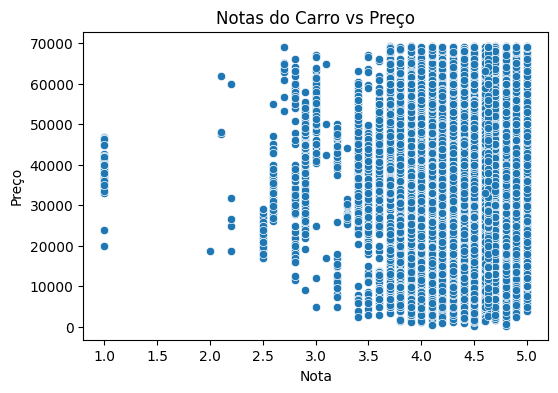

In [115]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='driver_rating', y='price', data=cars_df)
plt.title('Notas do Carro vs Preço')
plt.xlabel('Nota')
plt.ylabel('Preço')
plt.show()

Uma observação bastante curiosa é que a nota influencia menos no preço do carro do que a quantidade de avaliações. Padrão, aliás, parecido com o observado no sprint 1.

No primeiro sprint, a quantidade de avaliações influenciava mais na quantidade de vendas do que a própria média das notas por produto. Embora estejamos considerando grandezas diferentes (preço não é o mesmo que quantidade de vendas), ainda assim parece algo a ser relevante, pois ambos conectam o elemento financeiro com a quantidade de avaliações.

Outro ponto é que a correlação entre a quantidade de vendas e número de avaliações no sprint 1 era direta, enquanto aqui, a correlação entre preço por carro e número de avaliações é inversa.

## 2.19 Coluna ```price_drop```

Conforme recomendação nas mentorias, a coluna ```price_drop``` deverá ser ignorada. Isso porque trata-se de um vazamento de dados ou data leakage.

In [116]:
cars_df.drop('price_drop', axis=1, inplace=True)

## 3. Análise Exploratória dos Dados – pós-limpeza

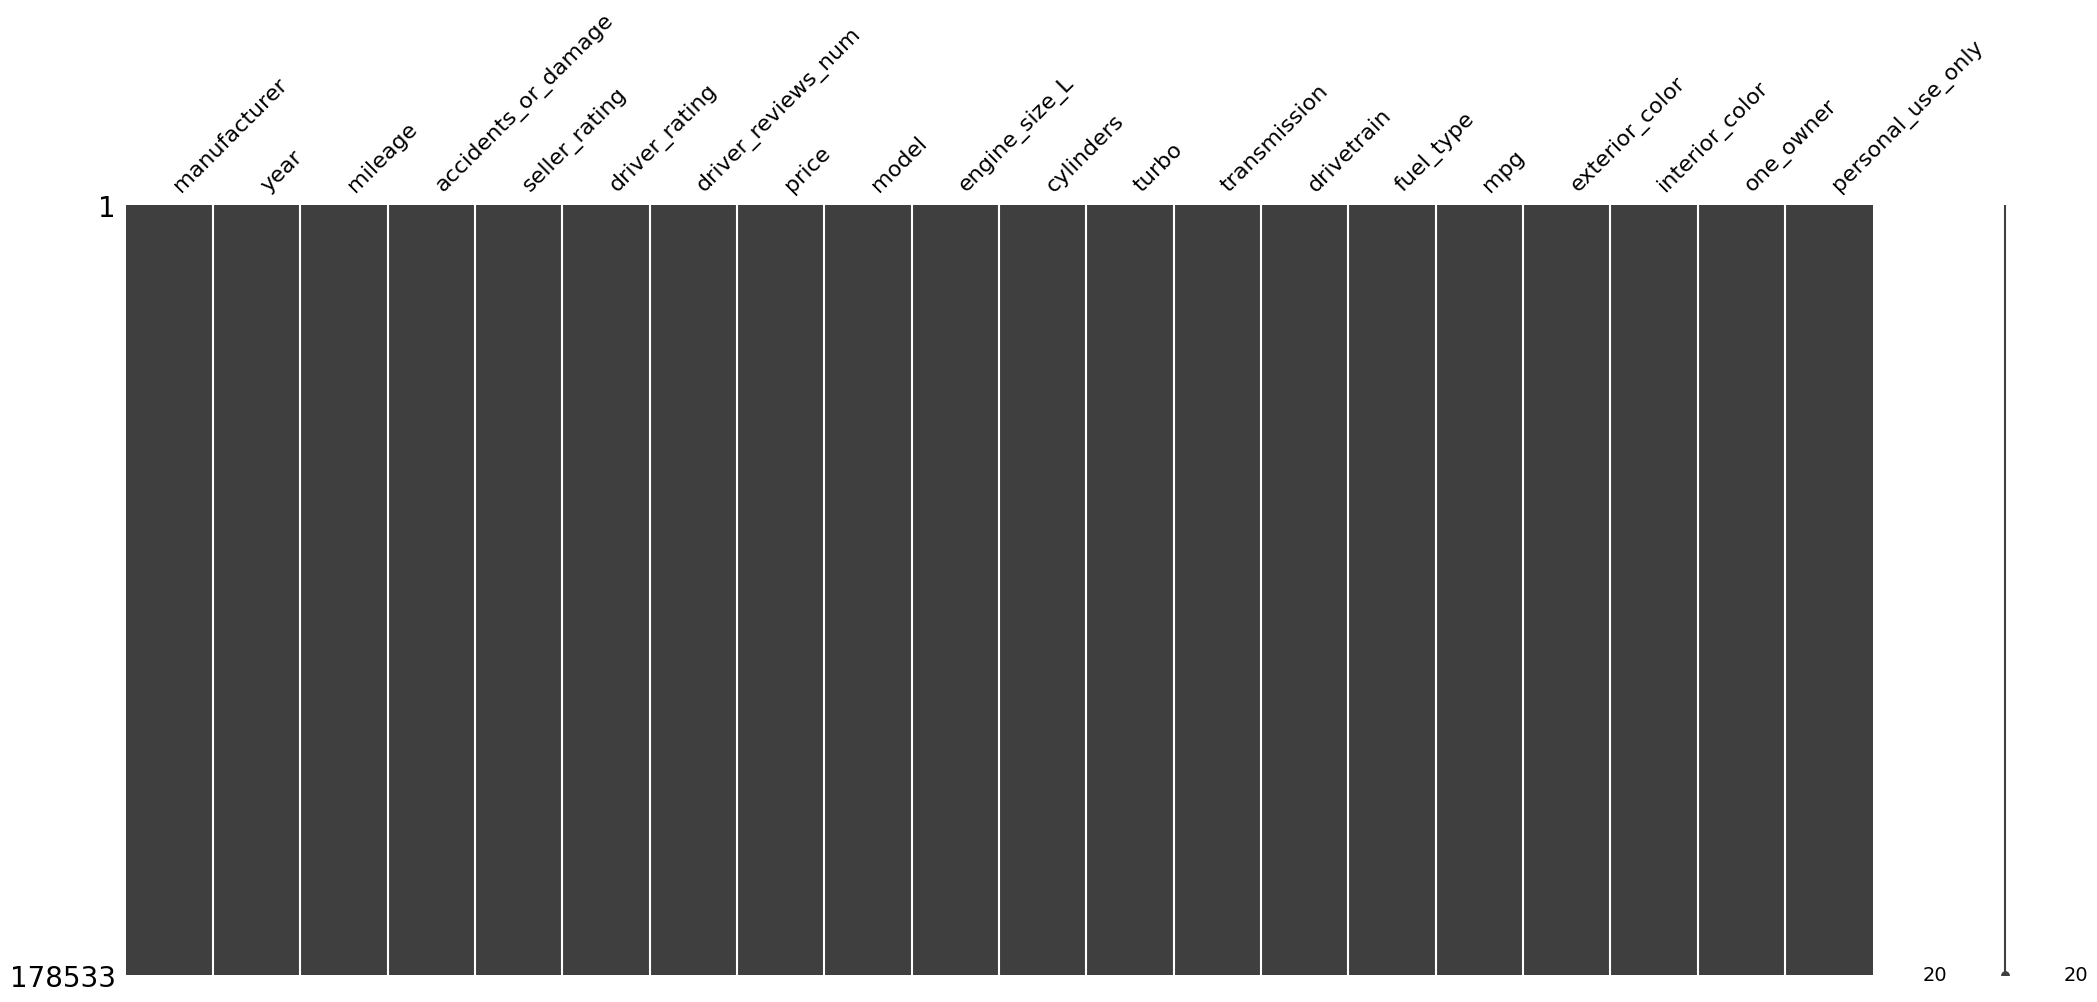

In [117]:
# verificando se ainda há dados faltantes
import missingno as msno
msno.matrix(cars_df)
plt.show()

## 3.1 Variáveis Categóricas e Numéricas

Importante ressaltarmos a diferença entre ambas.

* **Variáveis categóricas** – são aquelas que representam qualidade. Nesse estudo, serão consideradas categóricas as variáveis:
    * manufacturer, accidents_or_damage, model, turbo, transmission, drivetrain, fuel_type, exterior_color, interior_color, one_owner e personal_use_only.

* **Variáveis numéricas** - são as que representam quantidade. Serão assim consideradas as variáveis:
    * year, mileage, seller_rating, driver_rating, driver_reviews_num, price, engine_size_L, cylinders e mpg.

Houve grande dúvida sobre se ```year``` deveria ser considerada uma variável categórica ou numérica. Após reflexão mais aprofundada no item 2.2, ficou claro que o preço é se altera conforme o ano. Assim, podemos concluir que o ano de produção deve ser tratado aqui não como uma qualidade dos carros, mas como um fator quantitativo de aumento ou redução do preço. 

Assim, muito embora haja uma característica ordinal em ```year```, tal visão não representa a essência do que está sendo analisado aqui. Não estamos tratando o ano como uma característica tal como uma cor ou um modelo. E a relação entre ```year``` e ```price```reforça o seu caráter numérico em detrimento do categórico.

Agora, vamos calcular a correlação de Pearson entre as variáveis numéricas.


## 3.2 Matriz de Correlação de Pearson

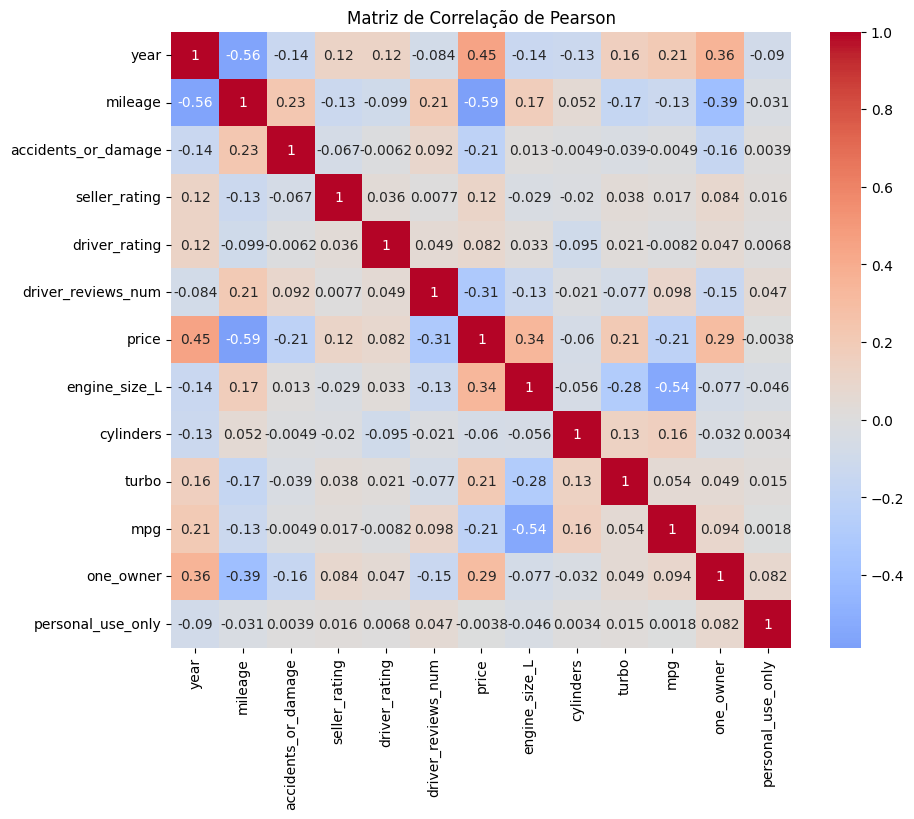

In [118]:
numeric_df = cars_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação de Pearson')
plt.show()

Interessante notar algumas relações. 

#### Relações positivas em relação a ```price```:
* ```year``` (ano da venda) (0.45)
* ```engine_size_L``` (tamanho do motor) (0.34)
* ```one_owner``` (carro de único dono) (0.29)
* há ```turbo``` (0.21)

#### Relações negativas em relação a ```price```:
* ```mileage``` (milhagem) (-0.59)
* ```driver_reviews_num``` (número de avaliações do carro) (-0.31)
* ```mpg``` (milhas por galão) (-0.21)
* ```accidents_or_damage``` (-0.21)

In [119]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178533 entries, 499001 to 269791
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   manufacturer         178533 non-null  object 
 1   year                 178533 non-null  int64  
 2   mileage              178533 non-null  float64
 3   accidents_or_damage  178533 non-null  float64
 4   seller_rating        178533 non-null  float64
 5   driver_rating        178533 non-null  float64
 6   driver_reviews_num   178533 non-null  float64
 7   price                178533 non-null  float64
 8   model                178533 non-null  object 
 9   engine_size_L        178533 non-null  float64
 10  cylinders            178533 non-null  float64
 11  turbo                178533 non-null  float64
 12  transmission         178533 non-null  object 
 13  drivetrain           178533 non-null  object 
 14  fuel_type            178533 non-null  object 
 15  mpg              

# 4. Machine Learning

## 4.1 Preparo dos Dados

In [120]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
import category_encoders as ce
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from category_encoders import BinaryEncoder


In [121]:
# Lista de colunas categóricas para o One-Hot Encoding
one_hot_cols = ['manufacturer', 'transmission', 'drivetrain', 'fuel_type', 'exterior_color', 'interior_color']

# Coluna categórica para Binary Encoding
binary_col = 'model'

# Colunas binárias que não precisam ser alteradas
binary_cols = ['one_owner', 'personal_use_only', 'turbo', 'accidents_or_damage']

# Colunas numéricas para normalização
numeric_cols = ['year', 'mileage', 'seller_rating', 'driver_rating', 'driver_reviews_num', 'engine_size_L', 'cylinders', 'mpg']

# Aplicar One-Hot Encoding usando get_dummies
one_hot_encoded_df = pd.get_dummies(cars_df[one_hot_cols], drop_first=True)

# Binary Encoding para a coluna 'model'
binary_encoder = ce.BinaryEncoder(cols=[binary_col])
binary_encoded_df = binary_encoder.fit_transform(cars_df[[binary_col]])

# Normalizar apenas as colunas numéricas
scaler = MinMaxScaler()
normalized_numeric = scaler.fit_transform(cars_df[numeric_cols])
normalized_numeric_df = pd.DataFrame(normalized_numeric, columns=numeric_cols, index=cars_df.index)

# Concatenar as partes transformadas e a variável target
final_df = pd.concat([normalized_numeric_df, binary_encoded_df, one_hot_encoded_df, cars_df[binary_cols], cars_df['price']], axis=1)

# Verificar o resultado final
final_df

,year,mileage,seller_rating,driver_rating,driver_reviews_num,engine_size_L,cylinders,mpg,model_0,model_1,...,interior_color_Green,interior_color_Orange,interior_color_Other,interior_color_Red,interior_color_White,one_owner,personal_use_only,turbo,accidents_or_damage,price
499001,0.92,0.37,0.82,0.93,0.11,0.25,0.20,0.23,0,0,...,False,False,False,False,False,0.00,0.00,0.00,0.00,14238.00
65860,0.92,0.46,0.95,0.90,0.07,0.40,0.00,0.14,0,0,...,False,False,False,False,False,0.00,1.00,0.00,0.00,12995.00
191410,0.93,0.20,0.90,0.85,0.19,0.18,0.20,0.23,0,0,...,False,False,False,False,False,0.00,1.00,0.00,1.00,12444.00
436095,0.93,0.37,0.79,0.90,0.33,0.18,0.20,0.20,0,0,...,False,False,False,False,False,0.00,0.00,0.00,0.00,12995.00
576188,0.92,0.38,0.90,0.85,0.26,0.25,0.20,0.21,0,0,...,False,False,False,False,False,1.00,1.00,0.00,1.00,13512.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268950,0.12,0.25,0.93,0.91,0.00,0.32,0.20,0.09,1,1,...,False,False,False,False,False,0.00,1.00,0.00,0.00,20995.00
269786,0.10,0.00,0.79,0.91,0.00,0.32,0.20,0.09,1,1,...,False,False,False,False,False,1.00,0.00,0.00,0.00,20000.00
268919,0.13,0.33,0.79,0.93,0.00,0.32,0.20,0.09,1,1,...,False,False,False,False,False,1.00,1.00,0.00,0.00,29995.00
268927,0.12,0.18,0.98,0.91,0.00,0.32,0.20,0.09,1,1,...,False,False,False,False,False,0.00,0.00,0.00,0.00,25968.00


In [122]:
X = final_df.drop('price', axis=1)
y = final_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## 4.2 Treinando os Modelos

In [131]:
def train_n_evaluate_model(model):
    # Treinar o modelo
    model.fit(X_train, y_train)
    
    # Previsões no conjunto de treinamento
    y_train_pred = model.predict(X_train)
    # Previsões no conjunto de teste
    y_test_pred = model.predict(X_test)
    
    # Métricas para o conjunto de treinamento
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)  # Calculando o RMSE
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Métricas para o conjunto de teste
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)  # Calculando o RMSE
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("Métricas para o conjunto de treinamento:")
    print(f"MSE: {train_mse}")
    print(f"RMSE: {train_rmse:.2f}")
    print(f"R²: {train_r2:.2%}")
    
    print("\nMétricas para o conjunto de teste:")
    print(f"MSE: {test_mse}")
    print(f"RMSE: {test_rmse:.2f}")
    print(f"R²: {test_r2:.2%}")
    
    # Visualização dos erros de previsão
    plt.figure(figsize=(12, 6))
    
    # Plotar os erros de previsão para o conjunto de treinamento
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
    plt.xlabel('Valores Reais')
    plt.ylabel('Previsões')
    plt.title('Conjunto de Treinamento')
    
    # Plotar os erros de previsão para o conjunto de teste
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel('Valores Reais')
    plt.ylabel('Previsões')
    plt.title('Conjunto de Teste')
    
    plt.show()

Random Forest:
Métricas para o conjunto de treinamento:
MSE: 1817171.929673265
RMSE: 1348.03
R²: 99.00%

Métricas para o conjunto de teste:
MSE: 12586055.81081185
RMSE: 3547.68
R²: 93.08%


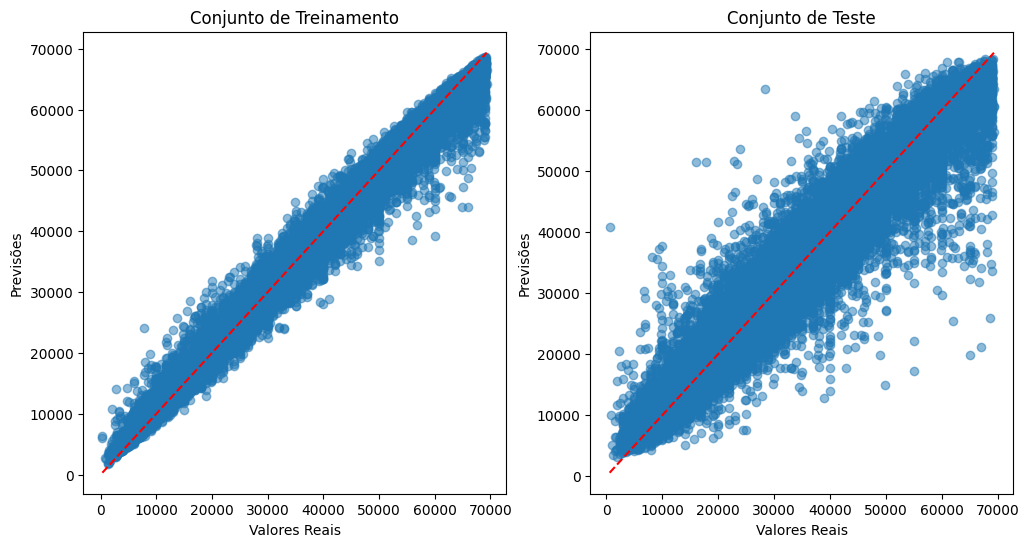

XGBoost:
Métricas para o conjunto de treinamento:
MSE: 13115326.904149367
RMSE: 3621.51
R²: 92.78%

Métricas para o conjunto de teste:
MSE: 15671627.323874403
RMSE: 3958.74
R²: 91.38%


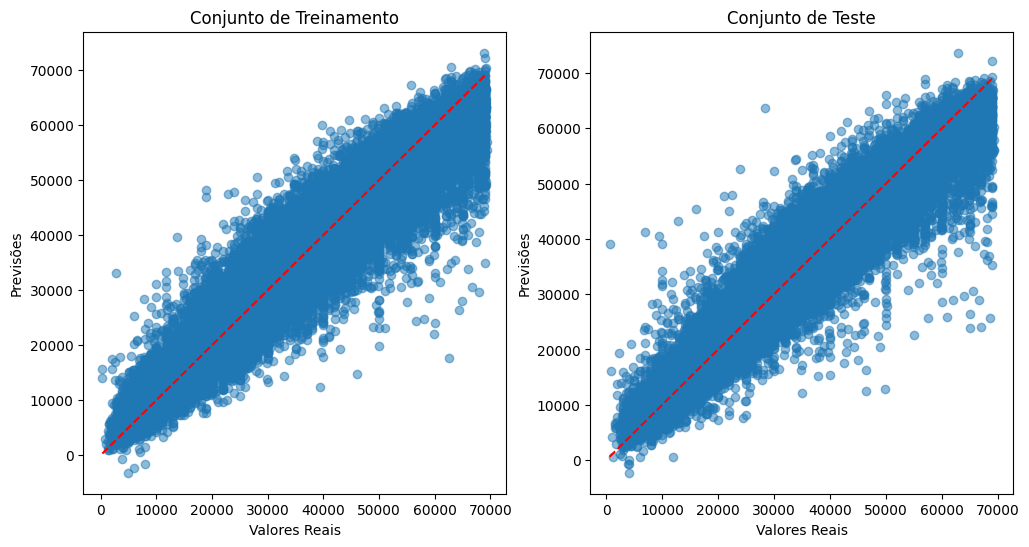

Ensemble de Modelos:
Métricas para o conjunto de treinamento:
MSE: 5544307.607321635
RMSE: 2354.64
R²: 96.95%

Métricas para o conjunto de teste:
MSE: 12555461.069038592
RMSE: 3543.37
R²: 93.09%


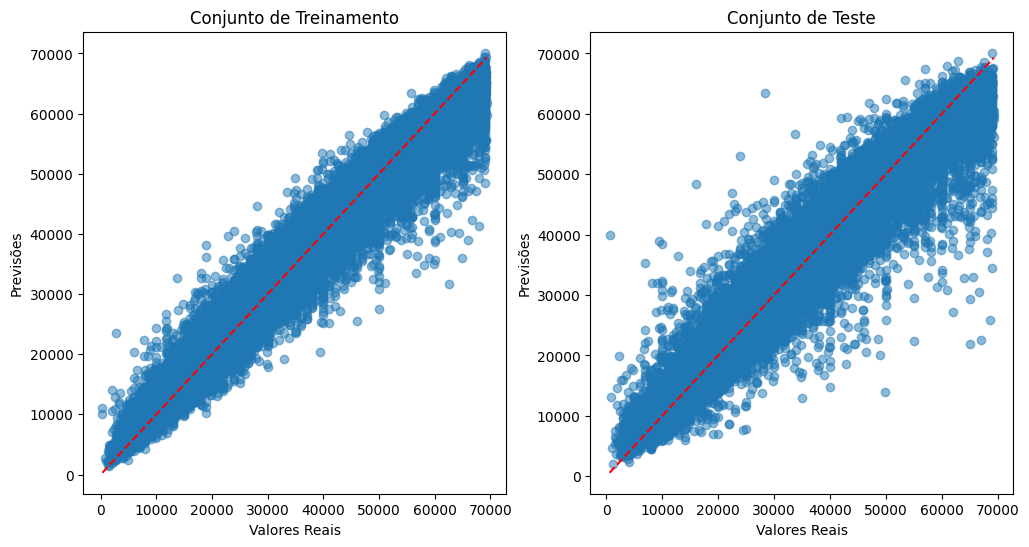

In [134]:
# Avaliar Random Forest
print("Random Forest:")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
train_n_evaluate_model(rf)

# Avaliar XGBoost
print("XGBoost:")
xgb = XGBRegressor(n_estimators=100, random_state=42)
train_n_evaluate_model(xgb)

# Criar e avaliar o ensemble de modelos
print("Ensemble de Modelos:")
ensemble = VotingRegressor(estimators=[('rf', rf), ('xgb', xgb)])
train_n_evaluate_model(ensemble)

### A Escolha das Métricas

Selecionei três métricas para avaliar os modelos de regressão: MSE, RMSE e R².

Escolhi MSE, pois ele é mais preciso em termos de penalização de erros. O RMSE, por outro lado, é mais fácil de interpretar. No caso do modelo de melhor desempenho neste estudo, o RMSE foi de 3543.37. Isso significa que a previsão de preços poderá, em média, ter um desvio de $3543.37, ao utilizar esse modelo.

E escolhi R² por ele medir o quanto a variação total na variável que queremos prever (variável dependente) pode ser explicada pelas variáveis independentes do modelo. Um R² alto demonstra que o modelo é capaz de explicar uma grande parte da variação nos preços dos carros, sendo portanto, capaz de generalizar bem para novos dados.

### Análise do Melhor Modelo

Podemos ver acima que o **melhor modelo** para o nosso caso é o **Ensemble de Modelos**. 

Embora o Random Forest tenha obtido o menor MSE e RMSE no conjunto de treinamento, há indícios de que houve overfitting. Isso porque o MSE e o RMSE são significativamente maiores no conjunto de teste, o que indica que o modelo se ajusta bem aos dados de treinamento, mas não generaliza tão bem para os dados de teste. A diferença de R² entre treinamento e teste também é considerável. 

Por outro lado, o Ensemble de Modelos, teve o melhor desempenho no conjunto de teste. Obteve o menor MSE e RMSE, e o maior R², ligeiramente maior que Random Forest. Além disso, a diferença entre R² de teste e R² de treinamento foi menor que Random Forest.

O XGBoost teve a menor diferença entre R² de teste e de treinamento. No entanto, obteve o pior desempenho, dentre os três modelos, no conjunto de teste, obtendo o maior MSE e RMSE, e o menor R² entre os três modelos.

## 4.3 Avaliação das Variáveis Mais Importantes

### 4.3.1. Ensemble de Modelos

In [195]:
# Treinar o ensemble de modelos
ensemble.fit(X_train, y_train)

# Obter a importância das features do ensemble
feature_importance_ensemble = np.mean([estimator.feature_importances_ for estimator in ensemble.estimators_], axis=0)

# Criar um DataFrame para visualizar as importâncias das features
feature_importance_ensemble_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance_ensemble})

# Ordenar as features pela importância
feature_importance_ensemble_df = feature_importance_ensemble_df.sort_values(by='Importance', ascending=False)

# Visualizar as top N features mais importantes
print("Top 10 Variáveis mais importantes no Ensemble de Modelos:")
print(feature_importance_ensemble_df.head(10))

Top 10 Variáveis mais importantes no Ensemble de Modelos:
                 Feature  Importance
0                   year        0.19
55        drivetrain_FWD        0.17
5          engine_size_L        0.09
4     driver_reviews_num        0.07
1                mileage        0.07
89                 turbo        0.04
7                    mpg        0.03
61      fuel_type_Hybrid        0.02
43  manufacturer_Porsche        0.02
49    manufacturer_Volvo        0.02


### 4.3.2 Random Forest

In [197]:
importances_rf = rf.feature_importances_
feature_names = X_train.columns
sorted_importances_rf = sorted(zip(feature_names, importances_rf), reverse=True)

# Criar um DataFrame para visualizar as importâncias das features
feature_importance_rf_df = pd.DataFrame(sorted_importances_rf, columns=['Feature', 'Importance'])

# Visualizar as top N features mais importantes
print("Top 10 Variáveis mais importantes para RandomForest:")
print(feature_importance_rf_df.head(10))


Top 10 Variáveis mais importantes para RandomForest:
                    Feature  Importance
0                      year        0.32
1                     turbo        0.02
2        transmission_Other        0.00
3       transmission_Manual        0.00
4  transmission_Dual-Clutch        0.00
5          transmission_CVT        0.00
6             seller_rating        0.01
7         personal_use_only        0.00
8                 one_owner        0.00
9                       mpg        0.03


### 4.3.3 XGBoost

In [191]:
xgb.fit(X_train, y_train)

# Obter a importância das features
feature_importance = xgb.feature_importances_

# Criar um DataFrame para visualizar as importâncias das features
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Ordenar as features pela importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar as top N features mais importantes
print("Top 10 Variáveis Mais Importantes para XGBoost:")
print(feature_importance_df.head(10))

Top 10 Features mais importantes:
                 Feature  Importance
55        drivetrain_FWD        0.20
0                   year        0.07
89                 turbo        0.06
5          engine_size_L        0.05
61      fuel_type_Hybrid        0.05
1                mileage        0.04
43  manufacturer_Porsche        0.03
49    manufacturer_Volvo        0.03
46    manufacturer_Tesla        0.03
42   manufacturer_Nissan        0.03


### 4.3.4 Conclusão – Variáveis Mais Importantes

Assim, tendo concluído que o melhor modelo para previsão do preço dos carros é Ensemble de Modelos, as duas variáveis mais importantes para esse modelo são:

* ```year```
* ```drivetrain_FWD```